In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from os import path
from utils import plot_report

import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 20.0]
HDFStore=pd.HDFStore

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np

import config
import os
from scipy.signal import resample


### Schema

0. x coordinate
1. y coordinate
2. timestamp
3. pen-up
4. azimuth angle
5. altitude angle
6. Pressure

In [2]:
# training parameters
seed= config.seed

dr=0.2
lr2=1e-3
lr1=1e-4
lr=8e-4

num_epochs=1000
mini_batch_size=53

main_units=64
secondary_units=16
last_unit=8
lstm_units=64
num_classes=1

features=['x','y','pen_up','pressure']
# features=['x','y']

doc_path = "/data/elekin/doc"
results_path = "/data/elekin/data/results/handwriting"

day="20220906"

print_sample=False

In [3]:
df = pd.read_csv(os.path.join(results_path,"biodarw_{}.csv".format(day))).set_index('subject_id')[features]
df.sample(5)

x      y  pen_up  pressure
subject_id                               
C107_2      4971   6470       1      1509
T006        5410  10700       1      1229
T011_2      5342   7555       1       843
T007        4750   8370       1      1229
C06_2       5980   8270       1      1550

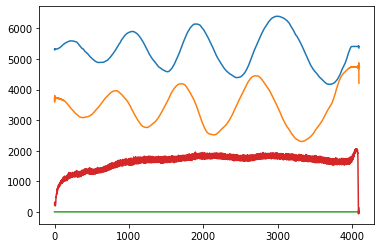

In [4]:
df_rs = df[features].groupby('subject_id').apply(resample, 4096)
plt.plot(df_rs['C01_1'])

In [5]:
df_list = []
for feature in features:
    df_list.append(df[feature])

df_rs_1D = pd.concat(df_list).groupby('subject_id').apply(resample, len(features)*4096)
np.array(df_rs_1D.values.tolist()).shape

(53, 16384)

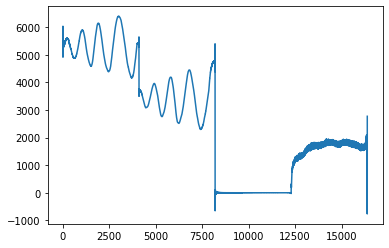

In [6]:
plt.plot(df_rs_1D['C01_1'])

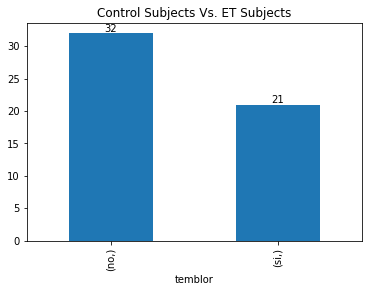

In [7]:
labels = pd.read_csv("/data/elekin/data/results/handwriting/binary_labels_20220906.csv", index_col=0).sort_index()
ax = labels.value_counts().plot.bar(title='Control Subjects Vs. ET Subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

In [8]:
np.array_equal(df_rs.index.values, labels.index.values)

True

In [9]:
from sklearn import preprocessing
#multi labels
#lb = preprocessing.LabelBinarizer()
#y = lb.fit_transform(labels).astype(np.int16)
#y.shape
#binary labels
le = LabelEncoder().fit(labels.values.ravel())
y = le.fit_transform(labels.values.ravel()).astype(np.int16)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int16)

In [10]:
X = np.array(df_rs_1D.values.tolist()).astype(np.float32)
X.shape

(53, 16384)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=38)

In [12]:
x_train.shape, x_test.shape

((35, 16384), (18, 16384))

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

if print_sample:
    for feat, targ in test_dataset.take(10):
        print ('Features test: {}, Target: {}'.format(feat, targ))

    for feat, targ in test_dataset.take(10):
        print ('Features train: {}, Target: {}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))

1 train batches and 1 test batches of 53 mini batch size and 0 steps per epoch


## FCNN ARCHITECTURE ANALISYS

Some training helpers functions

In [14]:
def get_callbacks(name):
    return [
        #tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, min_delta=1e-4),
        #tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, train_dataset, test_dataset, name, optimizer=None, max_epochs=1000):
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(name),
                        verbose=1, shuffle=False)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [15]:
size_histories = {}

In [16]:
num_features = x_train.shape[1]
tiny = tf.keras.models.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)])

size_histories['fcnn/tiny'] = compile_and_fit(tiny, train_dataset, 
                                              test_dataset,
                                              "fcnn/tiny", 
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1048640   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,048,705
Trainable params: 1,048,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 1s 705ms/step - loss: 1937.6851 - accuracy: 0.4571 - val_loss: 27581.7773 - val_accuracy: 0.7222
Epoch 2/1000
1/1 [==============================] - 0s 8ms/step - loss: 50008.8125 - accuracy: 0.5429 - val_loss: 20490.3789 - val_accuracy: 0.7222
Epoch 3/1000
1/1 [==============================] - 0s 8ms/step - loss: 37708.7188 - accuracy: 0.5429 - val_loss: 7094.0034 - val_accuracy: 0.722

1/1 [==============================] - 0s 8ms/step - loss: 245.6670 - accuracy: 0.8000 - val_loss: 182.4771 - val_accuracy: 0.7778
Epoch 53/1000
1/1 [==============================] - 0s 7ms/step - loss: 97.9299 - accuracy: 0.8857 - val_loss: 597.7100 - val_accuracy: 0.5556
Epoch 54/1000
1/1 [==============================] - 0s 8ms/step - loss: 336.9805 - accuracy: 0.8000 - val_loss: 214.2245 - val_accuracy: 0.7778
Epoch 55/1000
1/1 [==============================] - 0s 8ms/step - loss: 120.1814 - accuracy: 0.9429 - val_loss: 300.3067 - val_accuracy: 0.8889
Epoch 56/1000
1/1 [==============================] - 0s 7ms/step - loss: 166.2217 - accuracy: 0.8286 - val_loss: 266.6777 - val_accuracy: 0.8889
Epoch 57/1000
1/1 [==============================] - 0s 8ms/step - loss: 120.7331 - accuracy: 0.8286 - val_loss: 235.1410 - val_accuracy: 0.7778
Epoch 58/1000
1/1 [==============================] - 0s 7ms/step - loss: 125.2335 - accuracy: 0.9143 - val_loss: 510.6495 - val_accuracy: 0.6111


Epoch 109/1000
1/1 [==============================] - 0s 8ms/step - loss: 279.3904 - accuracy: 0.7429 - val_loss: 233.0792 - val_accuracy: 0.8333
Epoch 110/1000
1/1 [==============================] - 0s 7ms/step - loss: 23.5893 - accuracy: 0.9143 - val_loss: 408.1572 - val_accuracy: 0.6667
Epoch 111/1000
1/1 [==============================] - 0s 9ms/step - loss: 178.7076 - accuracy: 0.8286 - val_loss: 250.7864 - val_accuracy: 0.7778
Epoch 112/1000
1/1 [==============================] - 0s 7ms/step - loss: 48.7600 - accuracy: 0.9143 - val_loss: 286.2853 - val_accuracy: 0.8333
Epoch 113/1000
1/1 [==============================] - 0s 7ms/step - loss: 64.6414 - accuracy: 0.7714 - val_loss: 213.0331 - val_accuracy: 0.8333
Epoch 114/1000
1/1 [==============================] - 0s 9ms/step - loss: 24.7913 - accuracy: 0.9714 - val_loss: 423.8199 - val_accuracy: 0.6667
Epoch 115/1000
1/1 [==============================] - 0s 7ms/step - loss: 185.4203 - accuracy: 0.8286 - val_loss: 187.9344 - val

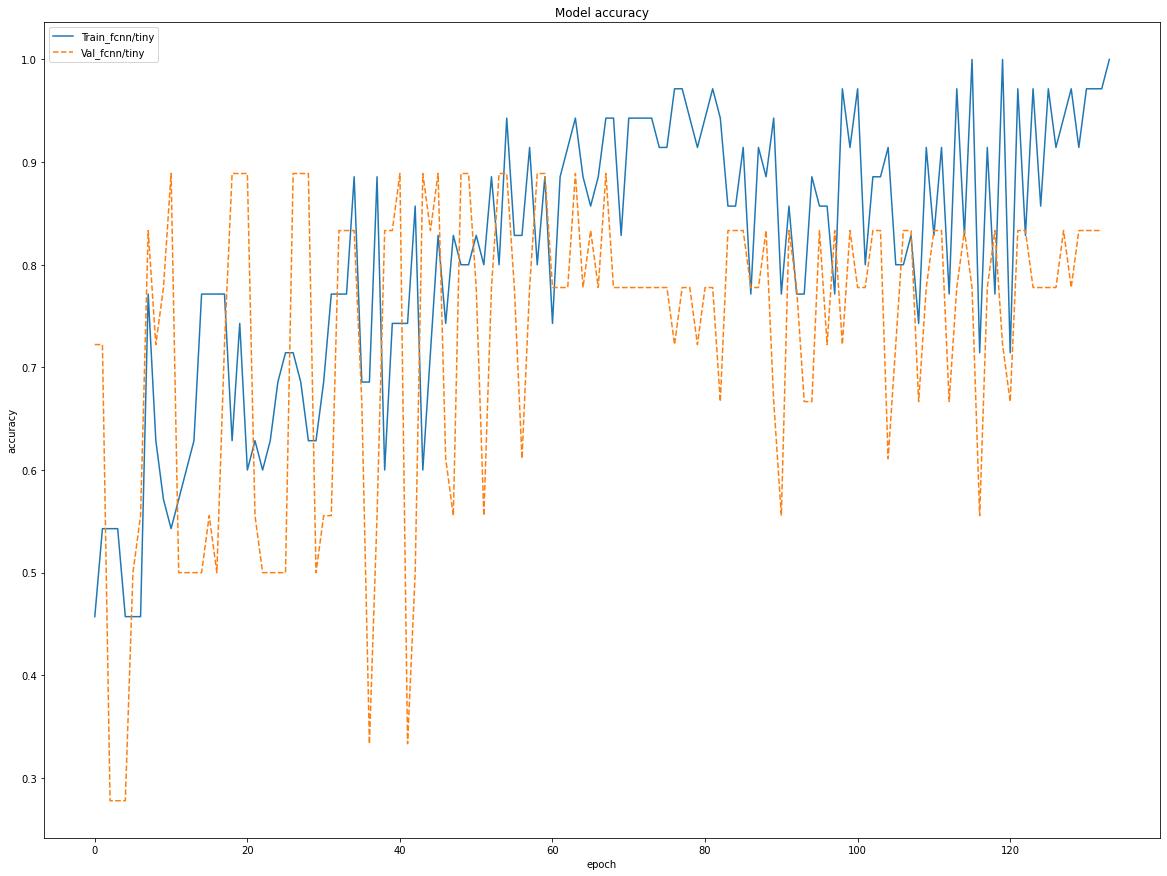

In [17]:
mpl.rcParams['figure.figsize'] = [20.0, 15.0]
plot_report(size_histories, metric='accuracy')

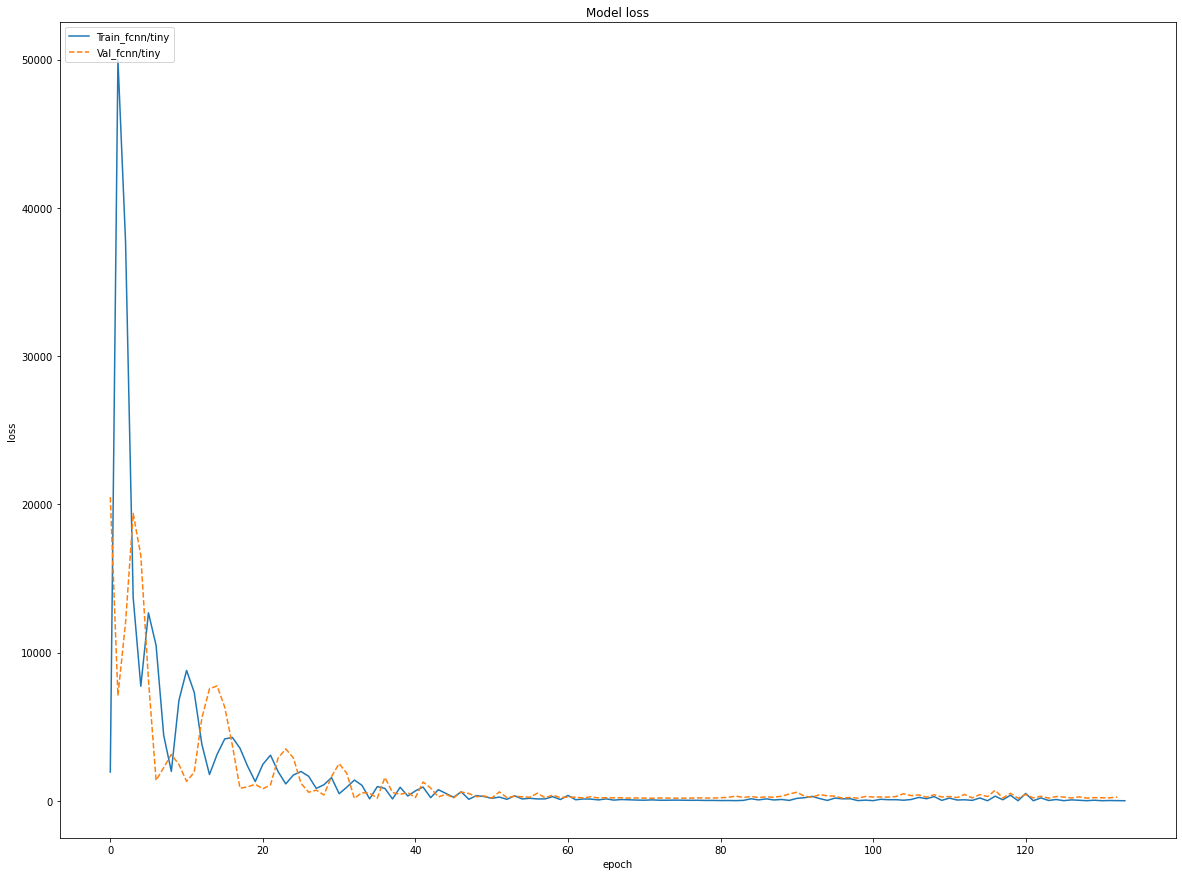

In [18]:
plot_report(size_histories, 'loss')

In [19]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/small'] = compile_and_fit(small_model, train_dataset, 
                                              test_dataset,'fcnn/small',
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/small'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/small'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1048640   
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,049,697
Trainable params: 1,049,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 0s 314ms/step - loss: 1749.1409 - accuracy: 0.5429 - val_loss: 22081.1602 - val_accuracy: 0.2778
Epoch 2/1000
1/1 [==============================] - 0s 9ms/step - loss: 15304.1963 - accuracy: 0.4571 - val_loss: 5509.0762 - val_accuracy: 0.2778
Epoch 3/1000
1

Epoch 53/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.5429 - val_loss: 0.6925 - val_accuracy: 0.7222
Epoch 54/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5429 - val_loss: 0.6924 - val_accuracy: 0.7222
Epoch 55/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.5429 - val_loss: 0.6924 - val_accuracy: 0.7222
Epoch 56/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.5429 - val_loss: 0.6923 - val_accuracy: 0.7222
Epoch 57/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5429 - val_loss: 0.6923 - val_accuracy: 0.7222
Epoch 58/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.5429 - val_loss: 0.6922 - val_accuracy: 0.7222
Epoch 59/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5429 - val_loss: 0.6922 - val_accuracy: 0.7222
Epoch 60/1000

1/1 [==============================] - 0s 8ms/step - loss: 0.6925 - accuracy: 0.5429 - val_loss: 0.6896 - val_accuracy: 0.7222
Epoch 112/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5429 - val_loss: 0.6896 - val_accuracy: 0.7222
Epoch 113/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5429 - val_loss: 0.6895 - val_accuracy: 0.7222
Epoch 114/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6925 - accuracy: 0.5429 - val_loss: 0.6895 - val_accuracy: 0.7222
Epoch 115/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5429 - val_loss: 0.6894 - val_accuracy: 0.7222
Epoch 116/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6925 - accuracy: 0.5429 - val_loss: 0.6894 - val_accuracy: 0.7222
Epoch 117/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6924 - accuracy: 0.5429 - val_loss: 0.6893 - val_accuracy: 0.7222
Epoch 118/1000
1/1 [=

Epoch 169/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6919 - accuracy: 0.5429 - val_loss: 0.6863 - val_accuracy: 0.7222
Epoch 170/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5429 - val_loss: 0.6863 - val_accuracy: 0.7222
Epoch 171/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6919 - accuracy: 0.5429 - val_loss: 0.6862 - val_accuracy: 0.7222
Epoch 172/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6919 - accuracy: 0.5429 - val_loss: 0.6861 - val_accuracy: 0.7222
Epoch 173/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5429 - val_loss: 0.6861 - val_accuracy: 0.7222
Epoch 174/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6919 - accuracy: 0.5429 - val_loss: 0.6860 - val_accuracy: 0.7222
Epoch 175/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5429 - val_loss: 0.6860 - val_accuracy: 0.7222
Epoch 

Epoch 227/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5429 - val_loss: 0.6829 - val_accuracy: 0.7222
Epoch 228/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6914 - accuracy: 0.5429 - val_loss: 0.6828 - val_accuracy: 0.7222
Epoch 229/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5429 - val_loss: 0.6828 - val_accuracy: 0.7222
Epoch 230/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6914 - accuracy: 0.5429 - val_loss: 0.6827 - val_accuracy: 0.7222
Epoch 231/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6914 - accuracy: 0.5429 - val_loss: 0.6826 - val_accuracy: 0.7222
Epoch 232/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5429 - val_loss: 0.6826 - val_accuracy: 0.7222
Epoch 233/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6914 - accuracy: 0.5429 - val_loss: 0.6825 - val_accuracy: 0.7222
Epoch 

Epoch 285/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.5429 - val_loss: 0.6795 - val_accuracy: 0.7222
Epoch 286/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6909 - accuracy: 0.5429 - val_loss: 0.6795 - val_accuracy: 0.7222
Epoch 287/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6909 - accuracy: 0.5429 - val_loss: 0.6794 - val_accuracy: 0.7222
Epoch 288/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.5429 - val_loss: 0.6793 - val_accuracy: 0.7222
Epoch 289/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6909 - accuracy: 0.5429 - val_loss: 0.6793 - val_accuracy: 0.7222
Epoch 290/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.5429 - val_loss: 0.6792 - val_accuracy: 0.7222
Epoch 291/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6909 - accuracy: 0.5429 - val_loss: 0.6792 - val_accuracy: 0.7222
Epoch 

Epoch 343/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6905 - accuracy: 0.5429 - val_loss: 0.6763 - val_accuracy: 0.7222
Epoch 344/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6905 - accuracy: 0.5429 - val_loss: 0.6763 - val_accuracy: 0.7222
Epoch 345/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6905 - accuracy: 0.5429 - val_loss: 0.6762 - val_accuracy: 0.7222
Epoch 346/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6905 - accuracy: 0.5429 - val_loss: 0.6762 - val_accuracy: 0.7222
Epoch 347/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6905 - accuracy: 0.5429 - val_loss: 0.6761 - val_accuracy: 0.7222
Epoch 348/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6905 - accuracy: 0.5429 - val_loss: 0.6761 - val_accuracy: 0.7222
Epoch 349/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6905 - accuracy: 0.5429 - val_loss: 0.6760 - val_accuracy: 0.7222
Epoch 

1/1 [==============================] - 0s 8ms/step - loss: 0.6902 - accuracy: 0.5429 - val_loss: 0.6735 - val_accuracy: 0.7222
Epoch 401/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6902 - accuracy: 0.5429 - val_loss: 0.6734 - val_accuracy: 0.7222
Epoch 402/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6902 - accuracy: 0.5429 - val_loss: 0.6734 - val_accuracy: 0.7222
Epoch 403/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6902 - accuracy: 0.5429 - val_loss: 0.6733 - val_accuracy: 0.7222
Epoch 404/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6902 - accuracy: 0.5429 - val_loss: 0.6733 - val_accuracy: 0.7222
Epoch 405/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6902 - accuracy: 0.5429 - val_loss: 0.6732 - val_accuracy: 0.7222
Epoch 406/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6902 - accuracy: 0.5429 - val_loss: 0.6732 - val_accuracy: 0.7222
Epoch 407/1000
1/1 [=

Epoch 458/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6900 - accuracy: 0.5429 - val_loss: 0.6709 - val_accuracy: 0.7222
Epoch 459/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6900 - accuracy: 0.5429 - val_loss: 0.6708 - val_accuracy: 0.7222
Epoch 460/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6900 - accuracy: 0.5429 - val_loss: 0.6708 - val_accuracy: 0.7222
Epoch 461/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6900 - accuracy: 0.5429 - val_loss: 0.6707 - val_accuracy: 0.7222
Epoch 462/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6900 - accuracy: 0.5429 - val_loss: 0.6707 - val_accuracy: 0.7222
Epoch 463/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6900 - accuracy: 0.5429 - val_loss: 0.6707 - val_accuracy: 0.7222
Epoch 464/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6900 - accuracy: 0.5429 - val_loss: 0.6706 - val_accuracy: 0.7222
Epoch 

Epoch 516/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6898 - accuracy: 0.5429 - val_loss: 0.6686 - val_accuracy: 0.7222
Epoch 517/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6898 - accuracy: 0.5429 - val_loss: 0.6686 - val_accuracy: 0.7222
Epoch 518/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6898 - accuracy: 0.5429 - val_loss: 0.6685 - val_accuracy: 0.7222
Epoch 519/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6898 - accuracy: 0.5429 - val_loss: 0.6685 - val_accuracy: 0.7222
Epoch 520/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6898 - accuracy: 0.5429 - val_loss: 0.6684 - val_accuracy: 0.7222
Epoch 521/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6898 - accuracy: 0.5429 - val_loss: 0.6684 - val_accuracy: 0.7222
Epoch 522/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6898 - accuracy: 0.5429 - val_loss: 0.6684 - val_accuracy: 0.7222
Epoch 

Epoch 574/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6897 - accuracy: 0.5429 - val_loss: 0.6666 - val_accuracy: 0.7222
Epoch 575/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6897 - accuracy: 0.5429 - val_loss: 0.6666 - val_accuracy: 0.7222
Epoch 576/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6897 - accuracy: 0.5429 - val_loss: 0.6666 - val_accuracy: 0.7222
Epoch 577/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6897 - accuracy: 0.5429 - val_loss: 0.6665 - val_accuracy: 0.7222
Epoch 578/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6897 - accuracy: 0.5429 - val_loss: 0.6665 - val_accuracy: 0.7222
Epoch 579/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6897 - accuracy: 0.5429 - val_loss: 0.6665 - val_accuracy: 0.7222
Epoch 580/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6897 - accuracy: 0.5429 - val_loss: 0.6664 - val_accuracy: 0.7222
Epoch 

Epoch 632/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6896 - accuracy: 0.5429 - val_loss: 0.6650 - val_accuracy: 0.7222
Epoch 633/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6896 - accuracy: 0.5429 - val_loss: 0.6649 - val_accuracy: 0.7222
Epoch 634/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6896 - accuracy: 0.5429 - val_loss: 0.6649 - val_accuracy: 0.7222
Epoch 635/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6896 - accuracy: 0.5429 - val_loss: 0.6649 - val_accuracy: 0.7222
Epoch 636/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6896 - accuracy: 0.5429 - val_loss: 0.6649 - val_accuracy: 0.7222
Epoch 637/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6896 - accuracy: 0.5429 - val_loss: 0.6648 - val_accuracy: 0.7222
Epoch 638/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6896 - accuracy: 0.5429 - val_loss: 0.6648 - val_accuracy: 0.7222
Epoch 

Epoch 690/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6896 - accuracy: 0.5429 - val_loss: 0.6636 - val_accuracy: 0.7222
Epoch 691/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6896 - accuracy: 0.5429 - val_loss: 0.6636 - val_accuracy: 0.7222
Epoch 692/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6896 - accuracy: 0.5429 - val_loss: 0.6635 - val_accuracy: 0.7222
Epoch 693/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6896 - accuracy: 0.5429 - val_loss: 0.6635 - val_accuracy: 0.7222
Epoch 694/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6896 - accuracy: 0.5429 - val_loss: 0.6635 - val_accuracy: 0.7222
Epoch 695/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6896 - accuracy: 0.5429 - val_loss: 0.6635 - val_accuracy: 0.7222
Epoch 696/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6896 - accuracy: 0.5429 - val_loss: 0.6634 - val_accuracy: 0.7222
Epoch 

1/1 [==============================] - 0s 9ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6625 - val_accuracy: 0.7222
Epoch 748/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6624 - val_accuracy: 0.7222
Epoch 749/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6624 - val_accuracy: 0.7222
Epoch 750/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6624 - val_accuracy: 0.7222
Epoch 751/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6624 - val_accuracy: 0.7222
Epoch 752/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6624 - val_accuracy: 0.7222
Epoch 753/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6624 - val_accuracy: 0.7222
Epoch 754/1000
1/1 

Epoch 805/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6615 - val_accuracy: 0.7222
Epoch 806/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6615 - val_accuracy: 0.7222
Epoch 807/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6615 - val_accuracy: 0.7222
Epoch 808/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6615 - val_accuracy: 0.7222
Epoch 809/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6615 - val_accuracy: 0.7222
Epoch 810/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6615 - val_accuracy: 0.7222
Epoch 811/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6615 - val_accuracy: 0.7222
Epoch 

Epoch 863/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6608 - val_accuracy: 0.7222
Epoch 864/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6608 - val_accuracy: 0.7222
Epoch 865/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6608 - val_accuracy: 0.7222
Epoch 866/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6608 - val_accuracy: 0.7222
Epoch 867/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6608 - val_accuracy: 0.7222
Epoch 868/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6608 - val_accuracy: 0.7222
Epoch 869/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6607 - val_accuracy: 0.7222
Epoch 

Epoch 921/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6602 - val_accuracy: 0.7222
Epoch 922/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6602 - val_accuracy: 0.7222
Epoch 923/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6602 - val_accuracy: 0.7222
Epoch 924/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6602 - val_accuracy: 0.7222
Epoch 925/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6602 - val_accuracy: 0.7222
Epoch 926/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6602 - val_accuracy: 0.7222
Epoch 927/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6602 - val_accuracy: 0.7222
Epoch 

Epoch 979/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6598 - val_accuracy: 0.7222
Epoch 980/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6598 - val_accuracy: 0.7222
Epoch 981/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6598 - val_accuracy: 0.7222
Epoch 982/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6598 - val_accuracy: 0.7222
Epoch 983/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6598 - val_accuracy: 0.7222
Epoch 984/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6598 - val_accuracy: 0.7222
Epoch 985/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6895 - accuracy: 0.5429 - val_loss: 0.6598 - val_accuracy: 0.7222
Epoch 

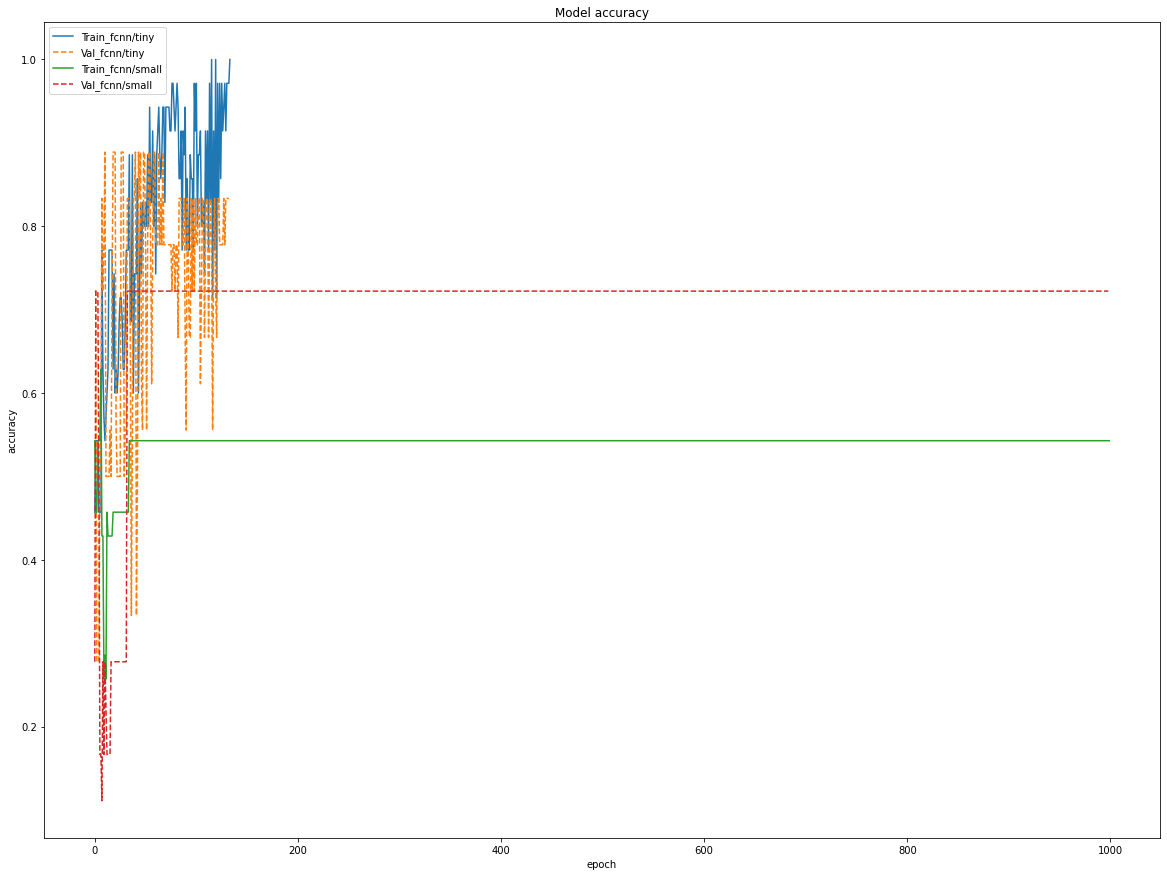

In [20]:
plot_report(size_histories)

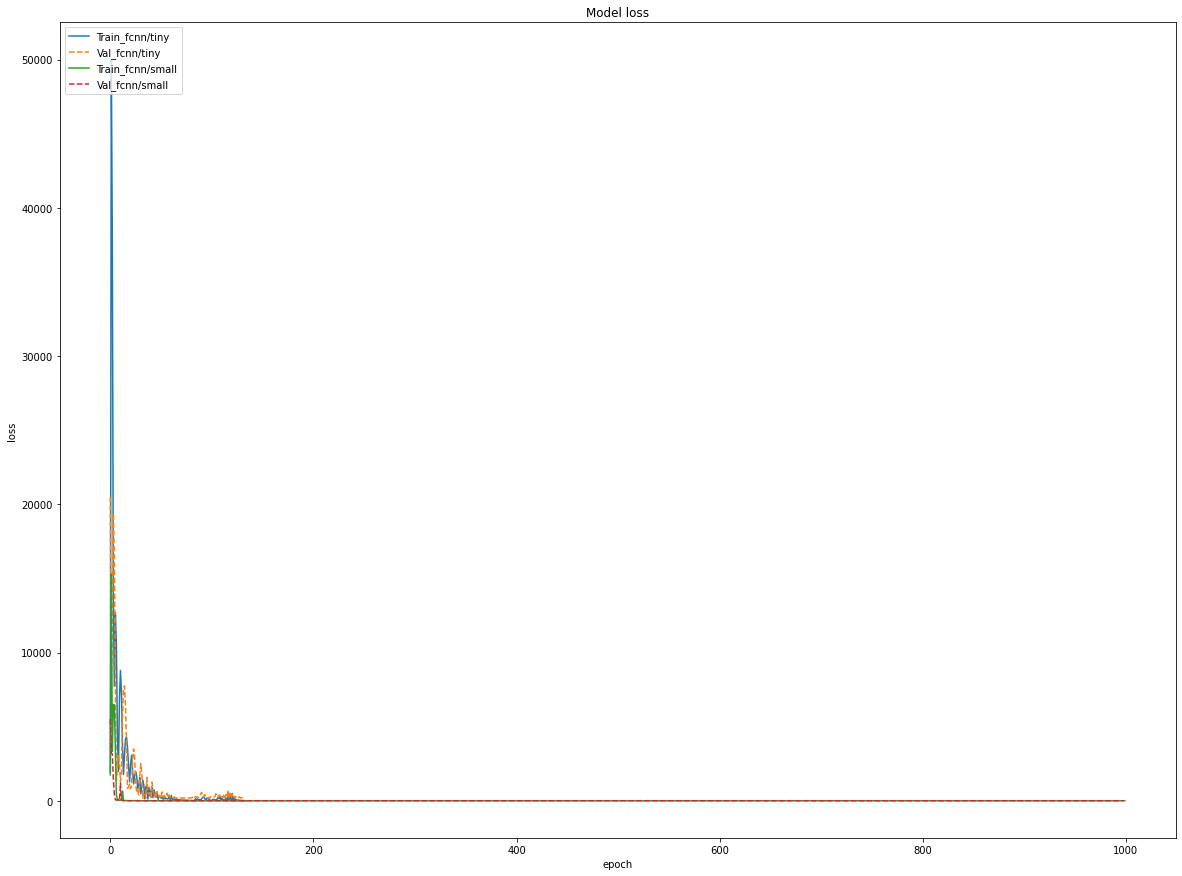

In [21]:
plot_report(size_histories, 'loss')

In [22]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),  
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/large'] = compile_and_fit(large_model, train_dataset, 
                                              test_dataset, "fcnn/large",
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer=get_optimizer(), 
                                              max_epochs=num_epochs)

print("Evaluation")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/large'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1048640   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,053,985
Trainable params: 1,053,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [============================

1/1 [==============================] - 0s 7ms/step - loss: 172.3697 - accuracy: 0.6286 - val_loss: 92.4449 - val_accuracy: 0.8333
Epoch 51/1000
1/1 [==============================] - 0s 9ms/step - loss: 190.4445 - accuracy: 0.6286 - val_loss: 29.5512 - val_accuracy: 0.8889
Epoch 52/1000
1/1 [==============================] - 0s 7ms/step - loss: 27.8355 - accuracy: 0.8571 - val_loss: 176.6127 - val_accuracy: 0.5000
Epoch 53/1000
1/1 [==============================] - 0s 8ms/step - loss: 96.0474 - accuracy: 0.7714 - val_loss: 181.5663 - val_accuracy: 0.5000
Epoch 54/1000
1/1 [==============================] - 0s 9ms/step - loss: 98.3401 - accuracy: 0.7714 - val_loss: 25.7517 - val_accuracy: 0.8333
Epoch 55/1000
1/1 [==============================] - 0s 7ms/step - loss: 18.1304 - accuracy: 0.8857 - val_loss: 63.9875 - val_accuracy: 0.8333
Epoch 56/1000
1/1 [==============================] - 0s 9ms/step - loss: 100.9666 - accuracy: 0.6571 - val_loss: 38.5920 - val_accuracy: 0.8889
Epoch 57

1/1 [==============================] - 0s 8ms/step - loss: 11.7502 - accuracy: 0.8000 - val_loss: 39.4035 - val_accuracy: 0.6667
Epoch 108/1000
1/1 [==============================] - 0s 8ms/step - loss: 19.8533 - accuracy: 0.8571 - val_loss: 28.7459 - val_accuracy: 0.7222
Epoch 109/1000
1/1 [==============================] - 0s 8ms/step - loss: 13.0903 - accuracy: 0.8571 - val_loss: 42.2488 - val_accuracy: 0.8333
Epoch 110/1000
1/1 [==============================] - 0s 7ms/step - loss: 32.5223 - accuracy: 0.7714 - val_loss: 20.8910 - val_accuracy: 0.7778
Epoch 111/1000
1/1 [==============================] - 0s 8ms/step - loss: 2.7463 - accuracy: 0.9143 - val_loss: 38.3726 - val_accuracy: 0.6667
Epoch 112/1000
1/1 [==============================] - 0s 9ms/step - loss: 18.8551 - accuracy: 0.8571 - val_loss: 19.5915 - val_accuracy: 0.7778
Epoch 113/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.7262 - accuracy: 0.9429 - val_loss: 38.3075 - val_accuracy: 0.8333
Epoch 114

1/1 [==============================] - 0s 10ms/step - loss: 2.3067 - accuracy: 0.9429 - val_loss: 44.8005 - val_accuracy: 0.8333
Epoch 165/1000
1/1 [==============================] - 0s 8ms/step - loss: 25.2511 - accuracy: 0.8000 - val_loss: 23.3364 - val_accuracy: 0.7778
Evaluation
train acc: 0.9714285731315613
test acc: 0.8888888955116272


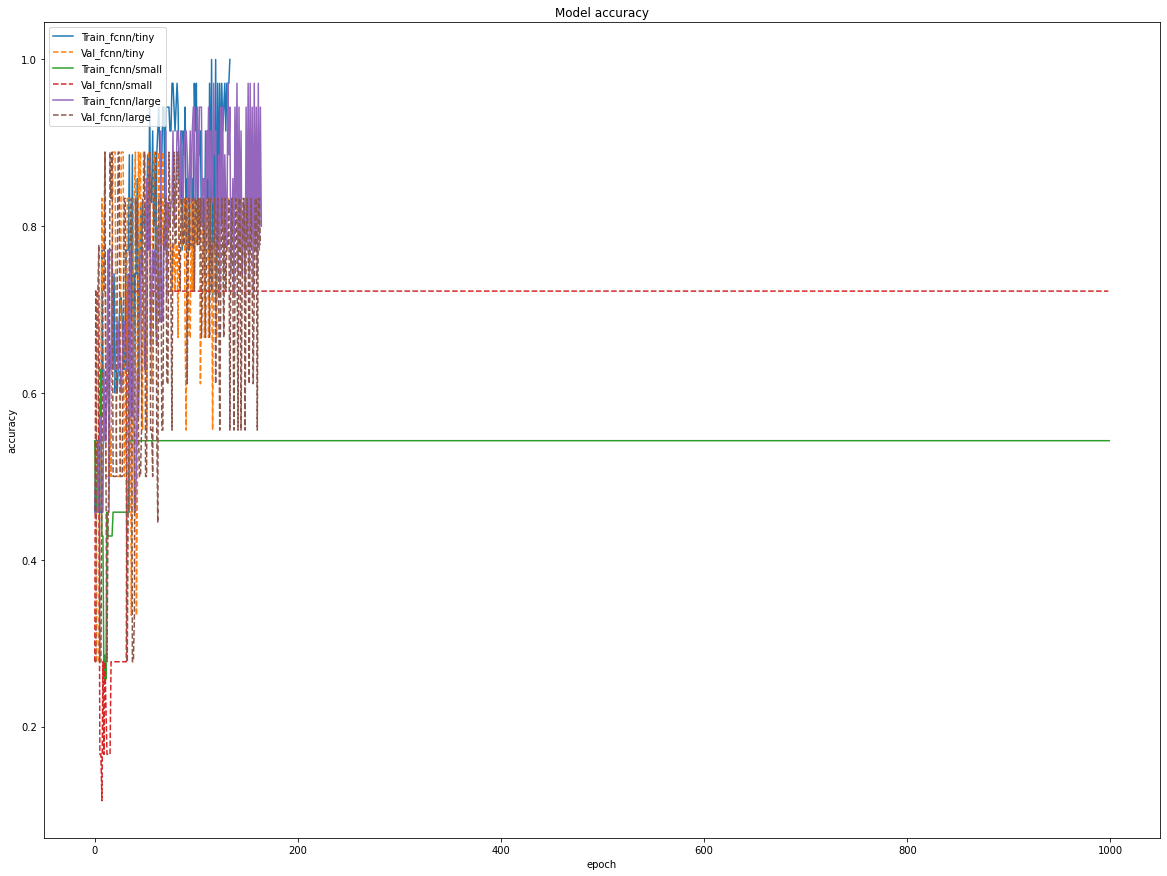

In [23]:
plot_report(size_histories)

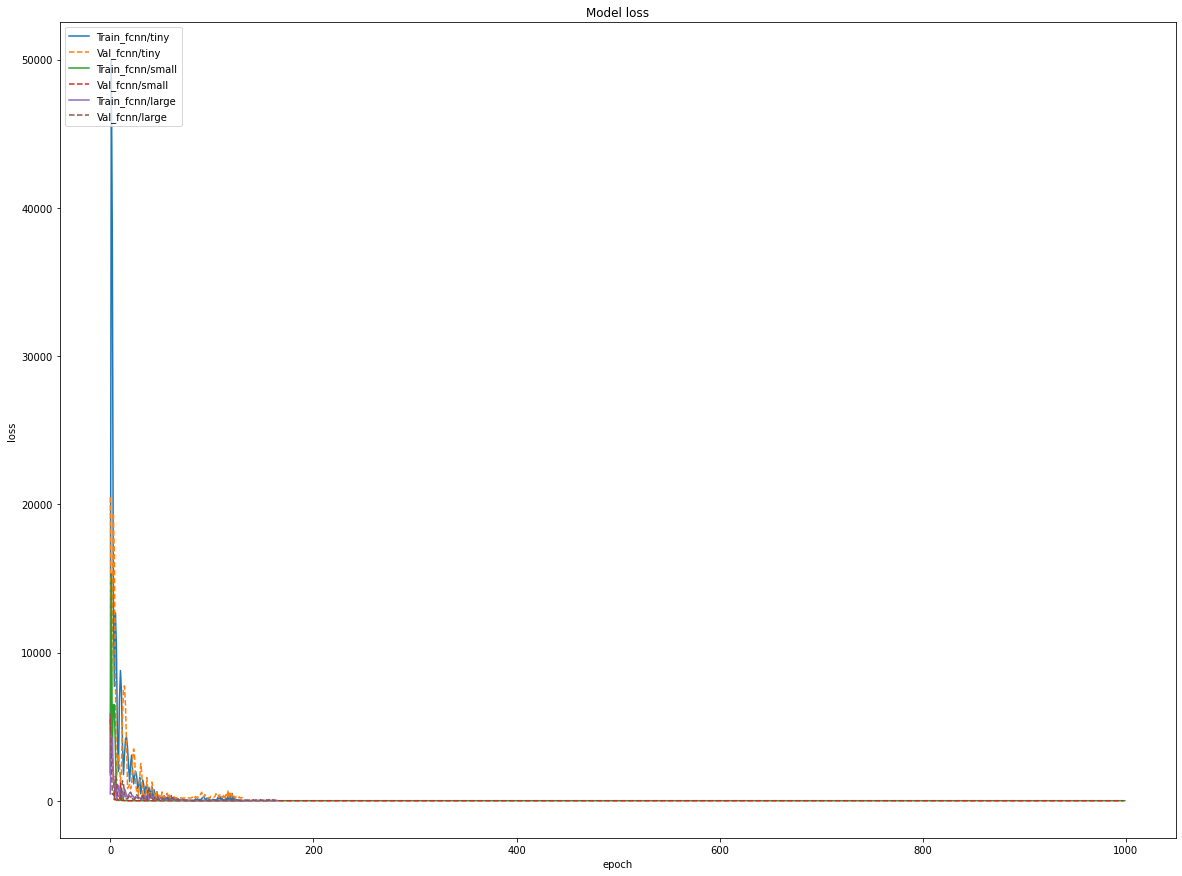

In [24]:
plot_report(size_histories, 'loss')

### Dropout

Although we got an accuracy of 0.75 looking at loss function chart is pretty obvious: There is overfiting. Now we have an overfitted NN let's make some adjustments to improve generalization capacity startin from dropout techniques.  

In [25]:
tiny_dropout = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/tiny/dropout'] = compile_and_fit(tiny_dropout, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/tiny/dropout", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATIO######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny/dropout'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny/dropout'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1048640   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 9

1/1 [==============================] - 0s 7ms/step - loss: 47.1054 - accuracy: 0.5714 - val_loss: 2.5187 - val_accuracy: 0.8333
Epoch 49/1000
1/1 [==============================] - 0s 8ms/step - loss: 90.9383 - accuracy: 0.4857 - val_loss: 17.8806 - val_accuracy: 0.7222
Epoch 50/1000
1/1 [==============================] - 0s 7ms/step - loss: 22.5527 - accuracy: 0.6286 - val_loss: 1.0737 - val_accuracy: 0.8889
Epoch 51/1000
1/1 [==============================] - 0s 8ms/step - loss: 89.4919 - accuracy: 0.7429 - val_loss: 0.4608 - val_accuracy: 0.8889
Epoch 52/1000
1/1 [==============================] - 0s 7ms/step - loss: 46.3752 - accuracy: 0.6857 - val_loss: 2.7934 - val_accuracy: 0.2778
Epoch 53/1000
1/1 [==============================] - 0s 7ms/step - loss: 5.5575 - accuracy: 0.5143 - val_loss: 6.8560 - val_accuracy: 0.2778
Epoch 54/1000
1/1 [==============================] - 0s 7ms/step - loss: 70.1347 - accuracy: 0.4000 - val_loss: 9.3179 - val_accuracy: 0.2778
Epoch 55/1000
1/1 [=

Epoch 106/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.7869 - accuracy: 0.5429 - val_loss: 0.6890 - val_accuracy: 0.7222
Epoch 107/1000
1/1 [==============================] - 0s 7ms/step - loss: 4.2742 - accuracy: 0.5429 - val_loss: 0.8595 - val_accuracy: 0.2778
Epoch 108/1000
1/1 [==============================] - 0s 8ms/step - loss: 20.1599 - accuracy: 0.4571 - val_loss: 0.8608 - val_accuracy: 0.2778
Epoch 109/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.7443 - accuracy: 0.4571 - val_loss: 0.6988 - val_accuracy: 0.2778
Epoch 110/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6949 - accuracy: 0.4000 - val_loss: 0.6023 - val_accuracy: 0.7222
Epoch 111/1000
1/1 [==============================] - 0s 8ms/step - loss: 10.0220 - accuracy: 0.5429 - val_loss: 0.6134 - val_accuracy: 0.7222
Epoch 112/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.7262 - accuracy: 0.5429 - val_loss: 0.7235 - val_accuracy: 0.2778
Epoc

1/1 [==============================] - 0s 7ms/step - loss: 4.9104 - accuracy: 0.5714 - val_loss: 0.6219 - val_accuracy: 0.7222
Epoch 164/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.6923 - accuracy: 0.5714 - val_loss: 0.7039 - val_accuracy: 0.2778
Epoch 165/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6977 - accuracy: 0.3429 - val_loss: 0.6732 - val_accuracy: 0.7222
Epoch 166/1000
1/1 [==============================] - 0s 8ms/step - loss: 6.7670 - accuracy: 0.5429 - val_loss: 0.6920 - val_accuracy: 0.7222
Epoch 167/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.6000 - val_loss: 0.6572 - val_accuracy: 0.7222
Epoch 168/1000
1/1 [==============================] - 0s 7ms/step - loss: 11.8545 - accuracy: 0.5429 - val_loss: 0.7457 - val_accuracy: 0.2778

#######################EVALUATIO######################
train acc: 0.7428571581840515
test acc: 0.8888888955116272


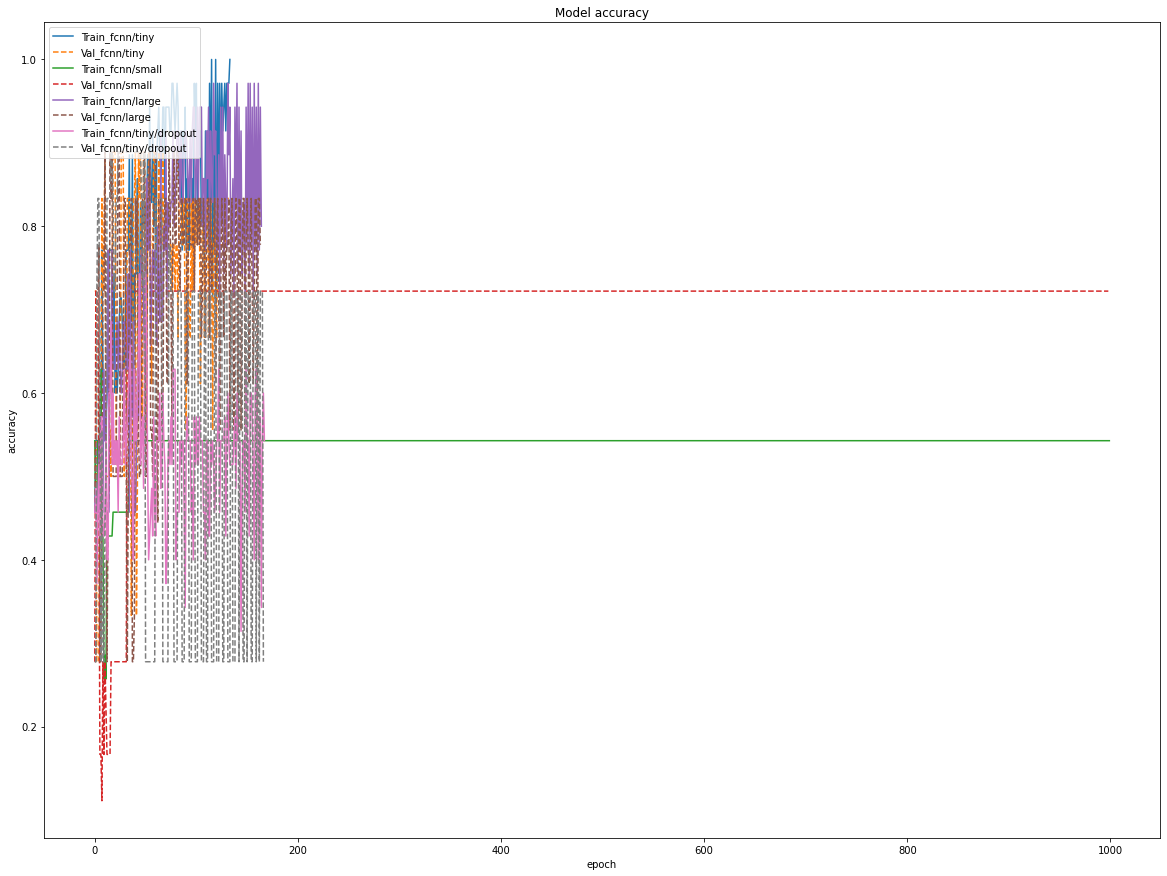

In [26]:
plot_report(size_histories)

Validation accuracy keeps improving more epoch with a total improvement from 0.75 to 0.81. Furthemore, the gap between training loss function and test loss function has been reduced.

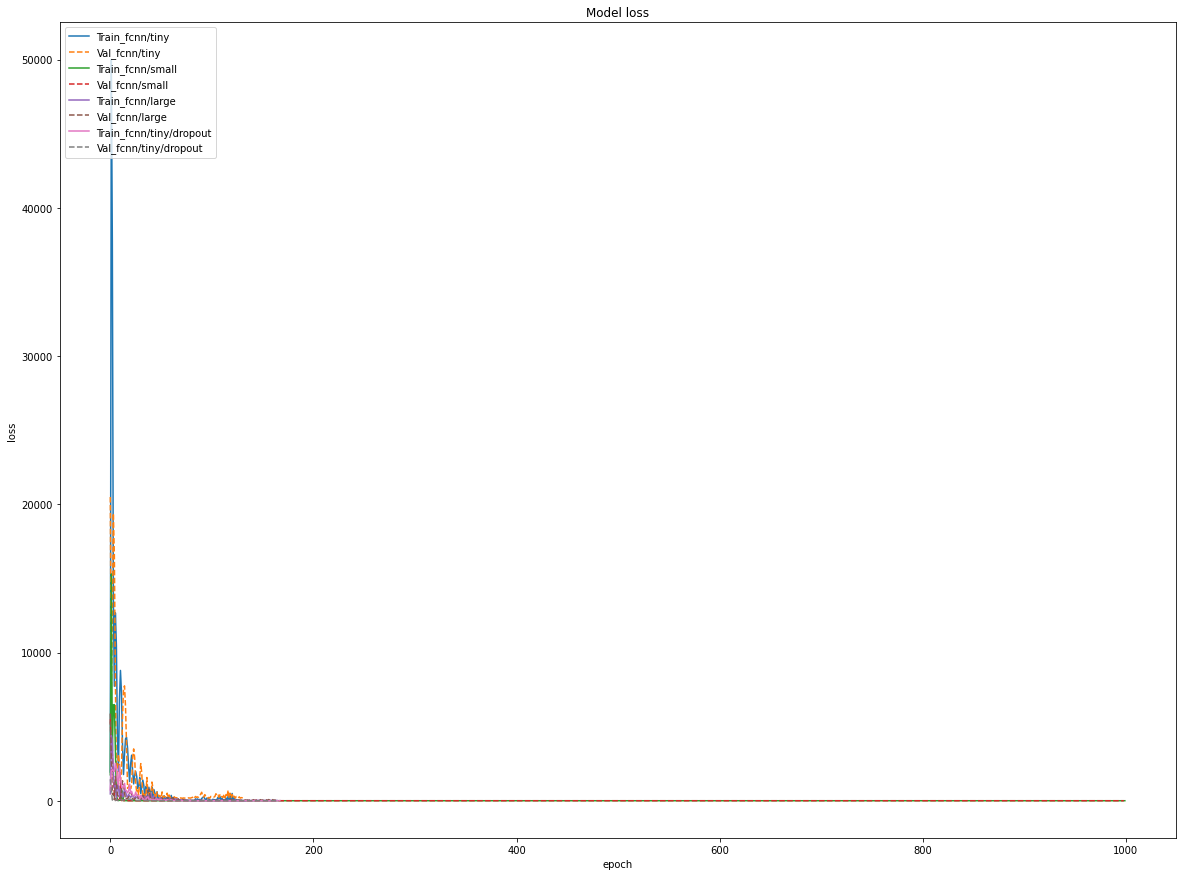

In [27]:
plot_report(size_histories, metric='loss')

### Kernel regularizer

In [28]:
# shutil.rmtree(logdir/'regularizers/tiny', ignore_errors=True)
# shutil.copytree(logdir/'fcnn/tiny', logdir/'regularizers/tiny')
regularizer_histories = {}
regularizer_histories['large'] = size_histories['fcnn/large']
regularizer_histories['dropout'] = size_histories['fcnn/tiny/dropout']

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [29]:
l2_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
regularizer_histories['l2'] = compile_and_fit(l2_model, train_dataset, 
                                              test_dataset, 
                                              optimizer=tf.keras.optimizers.Adam(lr),
                                              name="regularizers/l2")
# Evaluate the model on the test data using `evaluate`
print("\n#######################EVALUATIO######################")
print('train acc:', max(regularizer_histories['l2'].history["accuracy"]))
print('test acc:', max(regularizer_histories['l2'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1048640   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,053,985
Trainable params: 1,053,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [============================

1/1 [==============================] - 0s 8ms/step - loss: 33.6271 - accuracy: 0.8857 - val_loss: 207.1979 - val_accuracy: 0.5556
Epoch 51/1000
1/1 [==============================] - 0s 7ms/step - loss: 115.8681 - accuracy: 0.8000 - val_loss: 80.6339 - val_accuracy: 0.8333
Epoch 52/1000
1/1 [==============================] - 0s 8ms/step - loss: 28.7922 - accuracy: 0.8857 - val_loss: 181.1107 - val_accuracy: 0.8333
Epoch 53/1000
1/1 [==============================] - 0s 8ms/step - loss: 182.6467 - accuracy: 0.7429 - val_loss: 81.0339 - val_accuracy: 0.7222
Epoch 54/1000
1/1 [==============================] - 0s 7ms/step - loss: 40.1026 - accuracy: 0.9143 - val_loss: 326.7629 - val_accuracy: 0.5556
Epoch 55/1000
1/1 [==============================] - 0s 8ms/step - loss: 191.6764 - accuracy: 0.7143 - val_loss: 101.4360 - val_accuracy: 0.8333
Epoch 56/1000
1/1 [==============================] - 0s 7ms/step - loss: 57.6844 - accuracy: 0.8286 - val_loss: 149.5879 - val_accuracy: 0.8333
Epoch

1/1 [==============================] - 0s 7ms/step - loss: 21.2921 - accuracy: 0.8857 - val_loss: 120.6595 - val_accuracy: 0.7222
Epoch 108/1000
1/1 [==============================] - 0s 8ms/step - loss: 28.1805 - accuracy: 0.9143 - val_loss: 116.8480 - val_accuracy: 0.7222
Epoch 109/1000
1/1 [==============================] - 0s 8ms/step - loss: 24.0211 - accuracy: 0.9143 - val_loss: 133.4637 - val_accuracy: 0.8333
Epoch 110/1000
1/1 [==============================] - 0s 7ms/step - loss: 25.7385 - accuracy: 0.8571 - val_loss: 99.8506 - val_accuracy: 0.7778
Epoch 111/1000
1/1 [==============================] - 0s 8ms/step - loss: 9.5590 - accuracy: 0.9714 - val_loss: 113.1993 - val_accuracy: 0.7222
Epoch 112/1000
1/1 [==============================] - 0s 8ms/step - loss: 18.8330 - accuracy: 0.9143 - val_loss: 111.7718 - val_accuracy: 0.7778
Epoch 113/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.2899 - accuracy: 0.9714 - val_loss: 136.2680 - val_accuracy: 0.8333
Epo

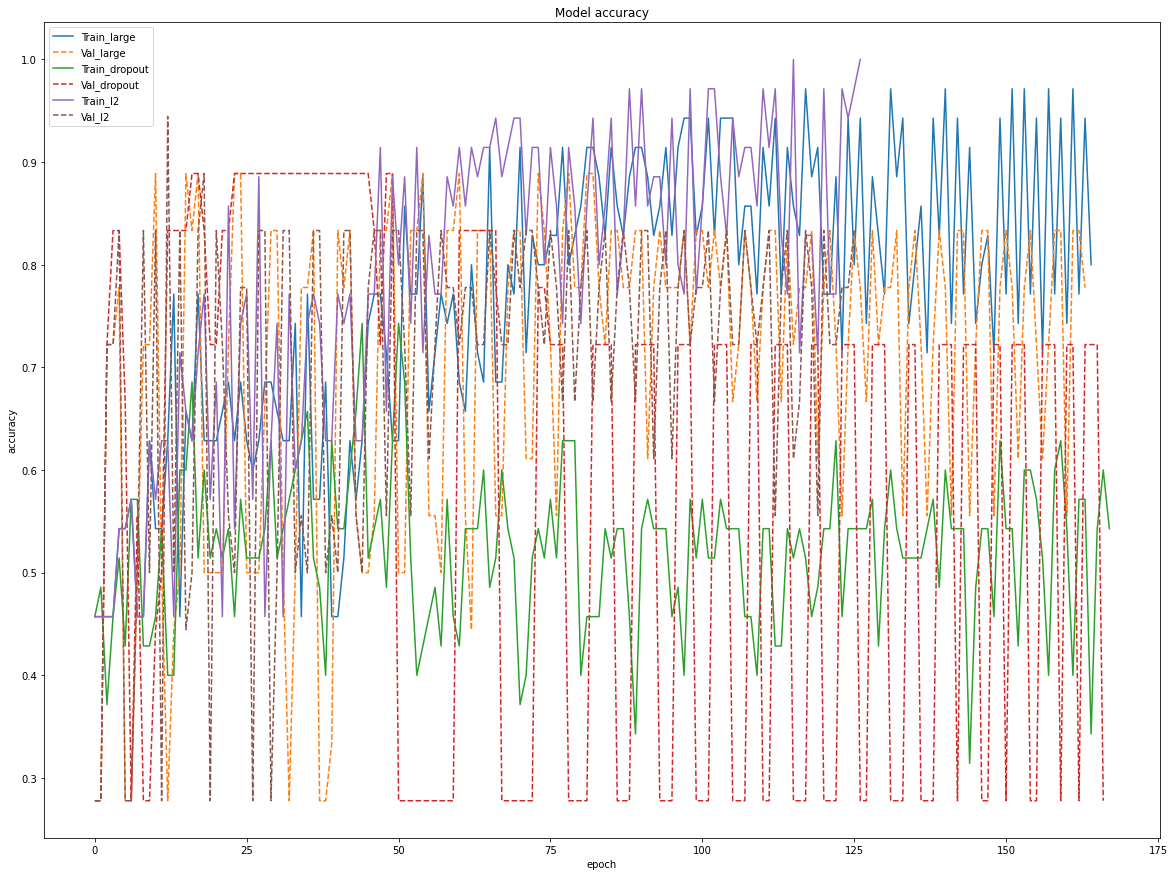

In [30]:
plot_report(regularizer_histories, 'accuracy')

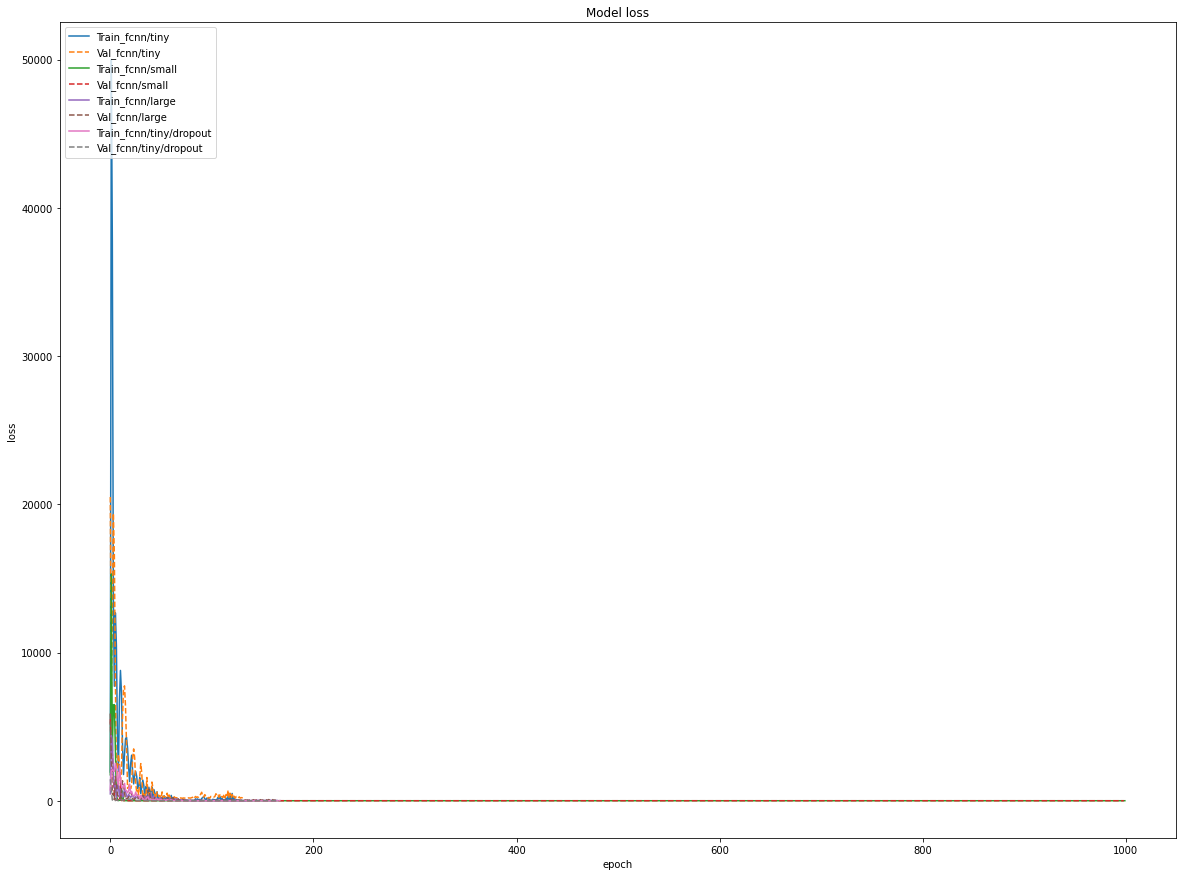

In [31]:
plot_report(size_histories, 'loss')

Now let's see what happens combining both techniques

In [32]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
combined_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    tf.keras.layers.Dropout(dr),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])

tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
regularizer_histories['combined'] = compile_and_fit(combined_model, train_dataset, test_dataset, "regularizers/combined",
                                                   optimizer=get_optimizer())

# Evaluate the model on the test data using `evaluate`
print()
print('train acc:', max(regularizer_histories['combined'].history["accuracy"]))
print('test acc:', max(regularizer_histories['combined'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1048640   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,053,985
Trainable params: 1,053,985
Non-

1/1 [==============================] - 0s 8ms/step - loss: 1.5775 - accuracy: 0.5714 - val_loss: 1.5162 - val_accuracy: 0.8333
Epoch 50/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.5737 - accuracy: 0.5714 - val_loss: 1.5134 - val_accuracy: 0.8333
Epoch 51/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.5710 - accuracy: 0.5714 - val_loss: 1.5107 - val_accuracy: 0.8333
Epoch 52/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.5683 - accuracy: 0.5714 - val_loss: 1.5080 - val_accuracy: 0.8333
Epoch 53/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.5323 - accuracy: 0.6286 - val_loss: 1.5186 - val_accuracy: 0.7778
Epoch 54/1000
1/1 [==============================] - 0s 7ms/step - loss: 3.1028 - accuracy: 0.6000 - val_loss: 1.6700 - val_accuracy: 0.8333
Epoch 55/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.4196 - accuracy: 0.6286 - val_loss: 1.9511 - val_accuracy: 0.8333
Epoch 56/1000
1/1 [========

1/1 [==============================] - 0s 8ms/step - loss: 1.4105 - accuracy: 0.6857 - val_loss: 1.4317 - val_accuracy: 0.7778
Epoch 108/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.3520 - accuracy: 0.7143 - val_loss: 1.4305 - val_accuracy: 0.7778
Epoch 109/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.4139 - accuracy: 0.6857 - val_loss: 1.4293 - val_accuracy: 0.7778
Epoch 110/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.5834 - accuracy: 0.6857 - val_loss: 1.4280 - val_accuracy: 0.7778
Epoch 111/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.3482 - accuracy: 0.7143 - val_loss: 1.4268 - val_accuracy: 0.7778
Epoch 112/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.4047 - accuracy: 0.6857 - val_loss: 1.4256 - val_accuracy: 0.7778
Epoch 113/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.3696 - accuracy: 0.6857 - val_loss: 1.4244 - val_accuracy: 0.7778
Epoch 114/1000
1/1 [=

Epoch 165/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.3990 - accuracy: 0.5714 - val_loss: 1.3782 - val_accuracy: 0.7778
Epoch 166/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.3985 - accuracy: 0.5714 - val_loss: 1.3776 - val_accuracy: 0.7778
Epoch 167/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.4332 - accuracy: 0.5429 - val_loss: 1.3770 - val_accuracy: 0.7778
Epoch 168/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.3974 - accuracy: 0.5714 - val_loss: 1.3764 - val_accuracy: 0.7778
Epoch 169/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.3968 - accuracy: 0.5714 - val_loss: 1.3758 - val_accuracy: 0.7778
Epoch 170/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.4225 - accuracy: 0.5429 - val_loss: 1.3754 - val_accuracy: 0.7778
Epoch 171/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.4017 - accuracy: 0.5714 - val_loss: 1.3749 - val_accuracy: 0.7778
Epoch 

Epoch 223/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.4037 - accuracy: 0.5429 - val_loss: 1.4018 - val_accuracy: 0.7222
Epoch 224/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.4033 - accuracy: 0.5429 - val_loss: 1.4016 - val_accuracy: 0.7222
Epoch 225/1000
1/1 [==============================] - 0s 9ms/step - loss: 1.4036 - accuracy: 0.5429 - val_loss: 1.4015 - val_accuracy: 0.7222
Epoch 226/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.4034 - accuracy: 0.5429 - val_loss: 1.4014 - val_accuracy: 0.7222
Epoch 227/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.4034 - accuracy: 0.5429 - val_loss: 1.4012 - val_accuracy: 0.7222
Epoch 228/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.4033 - accuracy: 0.5429 - val_loss: 1.4011 - val_accuracy: 0.7222
Epoch 229/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.4031 - accuracy: 0.5429 - val_loss: 1.4009 - val_accuracy: 0.7222
Epoch 

Epoch 281/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.3965 - accuracy: 0.5429 - val_loss: 1.3942 - val_accuracy: 0.7222
Epoch 282/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.3965 - accuracy: 0.5429 - val_loss: 1.3941 - val_accuracy: 0.7222

train acc: 0.8571428656578064
test acc: 0.8888888955116272


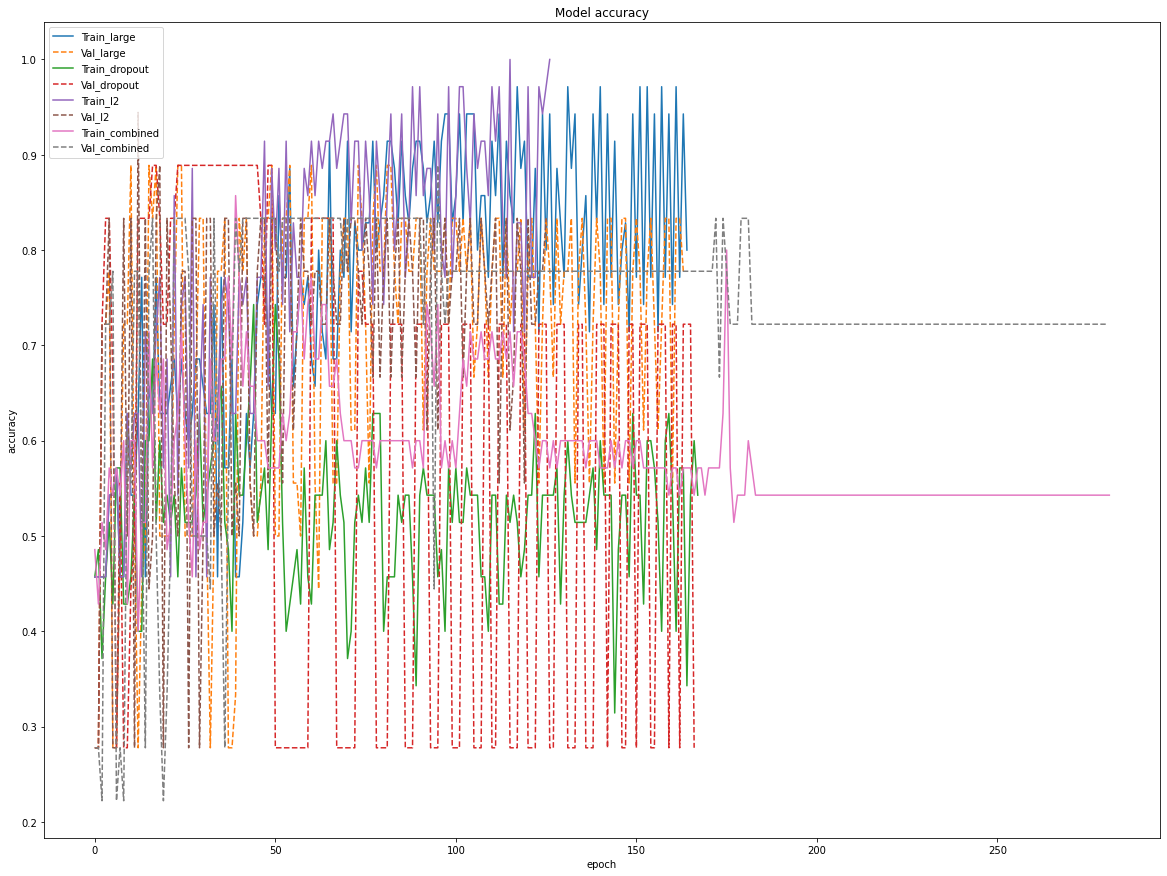

In [33]:
plot_report(regularizer_histories, 'accuracy')

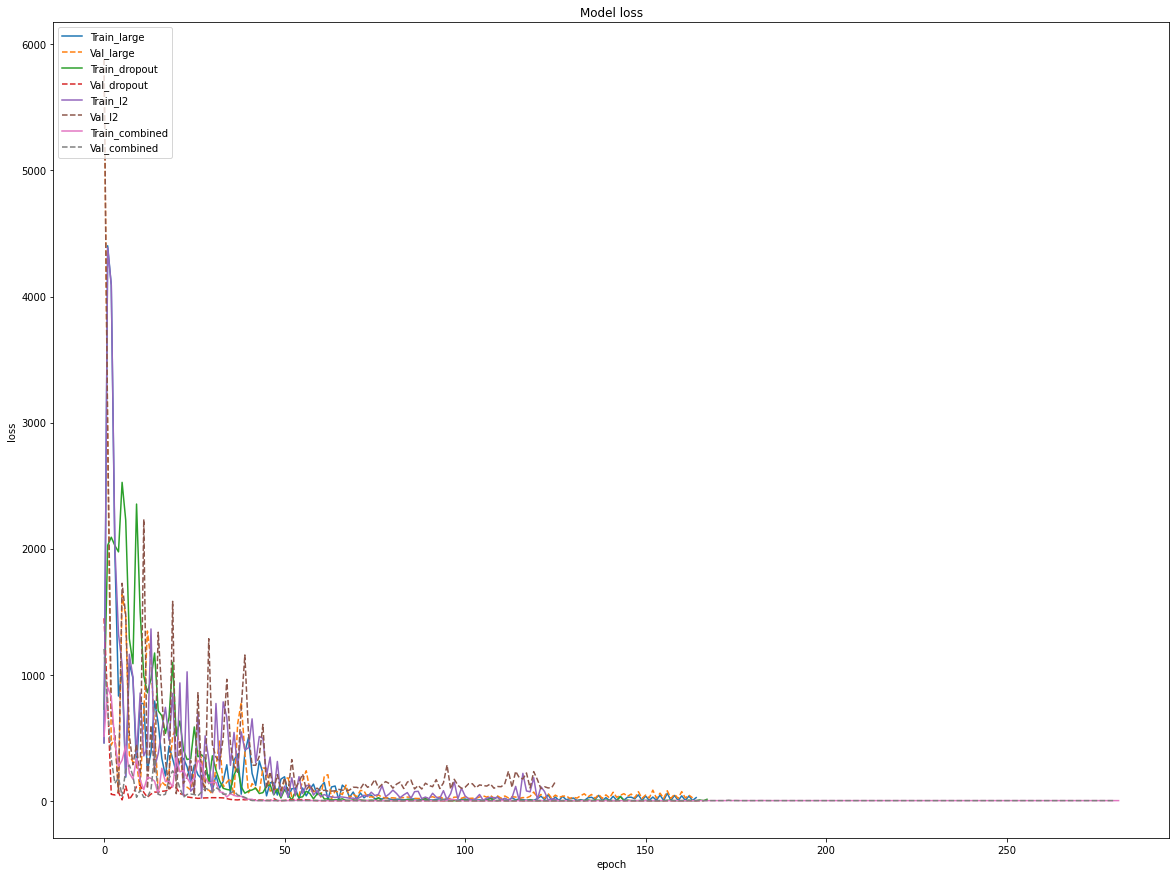

In [34]:
plot_report(regularizer_histories, 'loss')

## Batch Normalization

Batch normalization (also known as batch norm) is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling. It was proposed by Sergey Ioffe and Christian Szegedy in 2015.

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[Tensorflow implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)


In [35]:
batch_histories = {}
batch_histories['large'] = size_histories['fcnn/large']
batch_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [36]:
small_batch = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
batch_histories['fcnn/small/batch'] = compile_and_fit(small_batch, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/small/batch", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(batch_histories['fcnn/small/batch'].history["accuracy"]))
print('test acc:', max(batch_histories['fcnn/small/batch'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1048640   
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 batch_normalization_2 (Batc  (None, 16)               6

1/1 [==============================] - 0s 9ms/step - loss: 0.1452 - accuracy: 0.9714 - val_loss: 1.4333 - val_accuracy: 0.2778
Epoch 45/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.1540 - accuracy: 1.0000 - val_loss: 1.3372 - val_accuracy: 0.2778
Epoch 46/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.1099 - accuracy: 1.0000 - val_loss: 1.2530 - val_accuracy: 0.2778
Epoch 47/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.1519 - accuracy: 1.0000 - val_loss: 1.2026 - val_accuracy: 0.2778
Epoch 48/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.1738 - accuracy: 1.0000 - val_loss: 1.2180 - val_accuracy: 0.2778
Epoch 49/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.1503 - accuracy: 1.0000 - val_loss: 1.2855 - val_accuracy: 0.2778
Epoch 50/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.1353 - accuracy: 1.0000 - val_loss: 1.3256 - val_accuracy: 0.2778
Epoch 51/1000
1/1 [=====

Epoch 102/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.1210 - accuracy: 1.0000 - val_loss: 0.8067 - val_accuracy: 0.4444
Epoch 103/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0812 - accuracy: 1.0000 - val_loss: 0.8154 - val_accuracy: 0.4444
Epoch 104/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0823 - accuracy: 1.0000 - val_loss: 0.8110 - val_accuracy: 0.4444
Epoch 105/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0647 - accuracy: 1.0000 - val_loss: 0.7946 - val_accuracy: 0.4444
Epoch 106/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0740 - accuracy: 1.0000 - val_loss: 0.7632 - val_accuracy: 0.5000
Epoch 107/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0819 - accuracy: 1.0000 - val_loss: 0.7327 - val_accuracy: 0.5000
Epoch 108/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0738 - accuracy: 1.0000 - val_loss: 0.7072 - val_accuracy: 0.5556
Ep

1/1 [==============================] - 0s 10ms/step - loss: 0.0507 - accuracy: 1.0000 - val_loss: 0.5122 - val_accuracy: 0.8333
Epoch 160/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0626 - accuracy: 0.9714 - val_loss: 0.5218 - val_accuracy: 0.8333
Epoch 161/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0571 - accuracy: 1.0000 - val_loss: 0.5331 - val_accuracy: 0.7778
Epoch 162/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0761 - accuracy: 1.0000 - val_loss: 0.5363 - val_accuracy: 0.7778
Epoch 163/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0453 - accuracy: 1.0000 - val_loss: 0.5268 - val_accuracy: 0.8333
Epoch 164/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0671 - accuracy: 1.0000 - val_loss: 0.5051 - val_accuracy: 0.8333
Epoch 165/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0748 - accuracy: 1.0000 - val_loss: 0.4901 - val_accuracy: 0.8333
Epoch 166/1000
1/

Epoch 217/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0595 - accuracy: 1.0000 - val_loss: 0.5213 - val_accuracy: 0.7778
Epoch 218/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0486 - accuracy: 1.0000 - val_loss: 0.5338 - val_accuracy: 0.7778
Epoch 219/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0566 - accuracy: 1.0000 - val_loss: 0.5173 - val_accuracy: 0.7778
Epoch 220/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0323 - accuracy: 1.0000 - val_loss: 0.5158 - val_accuracy: 0.7778
Epoch 221/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0420 - accuracy: 1.0000 - val_loss: 0.4870 - val_accuracy: 0.7778
Epoch 222/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0300 - accuracy: 1.0000 - val_loss: 0.4625 - val_accuracy: 0.7778
Epoch 223/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0556 - accuracy: 1.0000 - val_loss: 0.4771 - val_accuracy: 0.7778
Ep

1/1 [==============================] - 0s 10ms/step - loss: 0.0204 - accuracy: 1.0000 - val_loss: 0.3900 - val_accuracy: 0.7778
Epoch 275/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0257 - accuracy: 1.0000 - val_loss: 0.3790 - val_accuracy: 0.7778
Epoch 276/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0212 - accuracy: 1.0000 - val_loss: 0.3502 - val_accuracy: 0.7778
Epoch 277/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0304 - accuracy: 1.0000 - val_loss: 0.3364 - val_accuracy: 0.7778
Epoch 278/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.3238 - val_accuracy: 0.7778
Epoch 279/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0595 - accuracy: 0.9714 - val_loss: 0.3168 - val_accuracy: 0.7778
Epoch 280/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.3150 - val_accuracy: 0.7778
Epoch 281/1000
1/1

1/1 [==============================] - 0s 9ms/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.2508 - val_accuracy: 0.8889
Epoch 332/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.2554 - val_accuracy: 0.8889
Epoch 333/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0271 - accuracy: 1.0000 - val_loss: 0.2679 - val_accuracy: 0.8333
Epoch 334/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0197 - accuracy: 1.0000 - val_loss: 0.2751 - val_accuracy: 0.8333
Epoch 335/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.2723 - val_accuracy: 0.8333
Epoch 336/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0208 - accuracy: 1.0000 - val_loss: 0.2684 - val_accuracy: 0.8333
Epoch 337/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0199 - accuracy: 1.0000 - val_loss: 0.2610 - val_accuracy: 0.8333
Epoch 338/1000
1/1 [

1/1 [==============================] - 0s 9ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.2152 - val_accuracy: 0.8889
Epoch 389/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0272 - accuracy: 1.0000 - val_loss: 0.2260 - val_accuracy: 0.8889
Epoch 390/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 0.2248 - val_accuracy: 0.8889
Epoch 391/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.2100 - val_accuracy: 0.8889
Epoch 392/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.1925 - val_accuracy: 0.8889
Epoch 393/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.1768 - val_accuracy: 0.9444
Epoch 394/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.1652 - val_accuracy: 0.9444
Epoch 395/1000
1/1 [=

1/1 [==============================] - 0s 9ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.0955 - val_accuracy: 1.0000
Epoch 446/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0947 - val_accuracy: 1.0000
Epoch 447/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.0936 - val_accuracy: 1.0000
Epoch 448/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.0926 - val_accuracy: 1.0000
Epoch 449/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.0926 - val_accuracy: 1.0000
Epoch 450/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.0924 - val_accuracy: 1.0000
Epoch 451/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.0932 - val_accuracy: 1.0000
Epoch 452/1000
1/1 

Epoch 503/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.1217 - val_accuracy: 0.9444
Epoch 504/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.1556 - val_accuracy: 0.9444
Epoch 505/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.1657 - val_accuracy: 0.9444
Epoch 506/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 0.1578 - val_accuracy: 0.9444
Epoch 507/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.1438 - val_accuracy: 0.9444
Epoch 508/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.1350 - val_accuracy: 0.9444
Epoch 509/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.1341 - val_accuracy: 1.0000
Epoc

1/1 [==============================] - 0s 10ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.1559 - val_accuracy: 0.9444
Epoch 561/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.1620 - val_accuracy: 0.9444
Epoch 562/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.1833 - val_accuracy: 0.9444
Epoch 563/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.2110 - val_accuracy: 0.8889
Epoch 564/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.2382 - val_accuracy: 0.8333
Epoch 565/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.2747 - val_accuracy: 0.8333
Epoch 566/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.3135 - val_accuracy: 0.8333
Epoch 567/1000
1/1

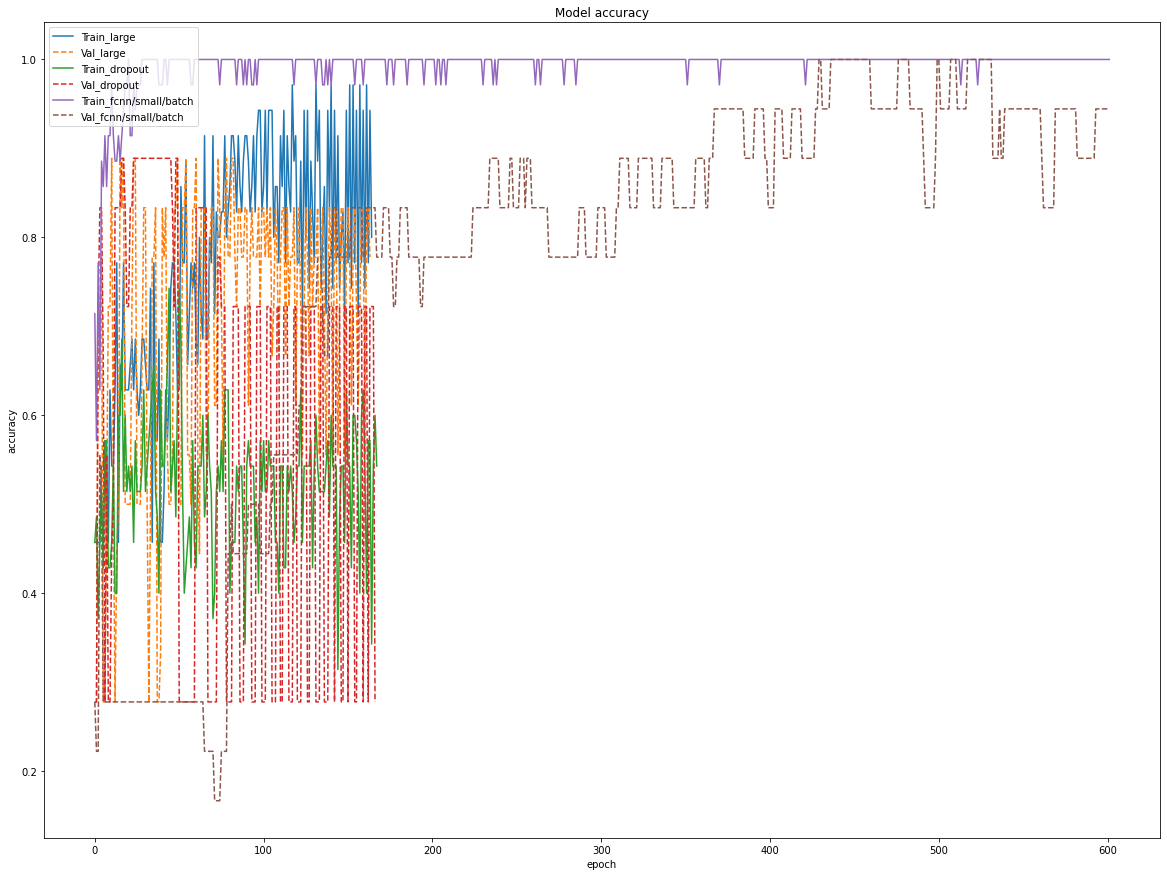

In [37]:
plot_report(batch_histories, 'accuracy')

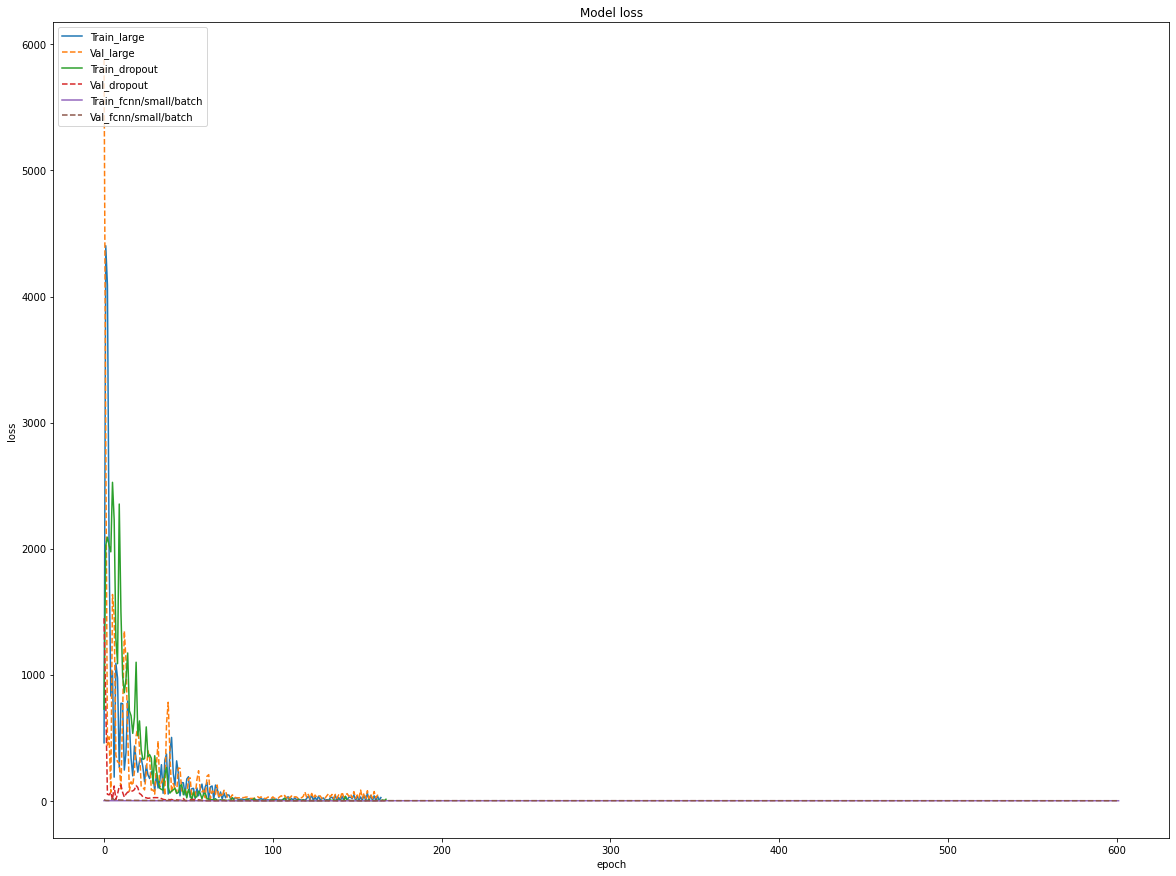

In [38]:
plot_report(batch_histories, 'loss')

## LSTM-FCNN

Univariate time series classification model, the Long Short Term Memory Fully Convolutional Network (LSTM-FCN) to capture time related information

In [39]:
takeX = np.array(df_rs.values.tolist())
X.shape

(53, 16384)

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=38)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

In [41]:
lstm_histories = {}
#lstm_histories['large'] = size_histories['fcnn/large']
#lstm_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [42]:
lstm_units=128
lstm_tiny_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[num_features,]),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)
                        ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
#     tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/tiny'] = compile_and_fit(lstm_tiny_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                               name="lstm/tiny")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/tiny'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/tiny'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 16384)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               8454656   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,456,209
Trainable params: 8,455,953
Non-trainable params: 256
____________________________________________

1/1 [==============================] - 0s 12ms/step - loss: 0.7490 - accuracy: 0.5714 - val_loss: 0.7436 - val_accuracy: 0.6667
Epoch 51/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.7298 - accuracy: 0.6286 - val_loss: 0.7408 - val_accuracy: 0.8889
Epoch 52/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.7353 - accuracy: 0.6286 - val_loss: 0.7508 - val_accuracy: 0.6667
Epoch 53/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.7645 - accuracy: 0.4571 - val_loss: 0.7930 - val_accuracy: 0.3889
Epoch 54/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.7802 - accuracy: 0.4571 - val_loss: 0.7803 - val_accuracy: 0.5000
Epoch 55/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.7367 - accuracy: 0.8000 - val_loss: 0.7795 - val_accuracy: 0.3889
Epoch 56/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.7446 - accuracy: 0.6857 - val_loss: 0.7944 - val_accuracy: 0.2778
Epoch 57/1000
1/1 [=

Epoch 108/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7240 - accuracy: 0.7143 - val_loss: 0.7780 - val_accuracy: 0.5000
Epoch 109/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7251 - accuracy: 0.6857 - val_loss: 0.7831 - val_accuracy: 0.5000
Epoch 110/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7202 - accuracy: 0.7143 - val_loss: 0.7858 - val_accuracy: 0.4444
Epoch 111/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.7213 - accuracy: 0.7143 - val_loss: 0.7882 - val_accuracy: 0.4444
Epoch 112/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7124 - accuracy: 0.7714 - val_loss: 0.7774 - val_accuracy: 0.4444
Epoch 113/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7073 - accuracy: 0.8000 - val_loss: 0.7715 - val_accuracy: 0.4444
Epoch 114/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.7082 - accuracy: 0.8000 - val_loss: 0.7699 - val_accuracy: 0.4444

1/1 [==============================] - 0s 13ms/step - loss: 0.6788 - accuracy: 0.7429 - val_loss: 0.6458 - val_accuracy: 0.7222
Epoch 166/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.6649 - accuracy: 0.7714 - val_loss: 0.6491 - val_accuracy: 0.7222
Epoch 167/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.6605 - accuracy: 0.7714 - val_loss: 0.6501 - val_accuracy: 0.7222
Epoch 168/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.6629 - accuracy: 0.7714 - val_loss: 0.6498 - val_accuracy: 0.7222
Epoch 169/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.6621 - accuracy: 0.7714 - val_loss: 0.6495 - val_accuracy: 0.7222
Epoch 170/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.6614 - accuracy: 0.7714 - val_loss: 0.6492 - val_accuracy: 0.7222
Epoch 171/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.6661 - accuracy: 0.7714 - val_loss: 0.6487 - val_accuracy: 0.7222
Epoch 172/1000

1/1 [==============================] - 0s 13ms/step - loss: 0.7466 - accuracy: 0.6286 - val_loss: 0.7075 - val_accuracy: 0.8333
Epoch 223/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7463 - accuracy: 0.6286 - val_loss: 0.7073 - val_accuracy: 0.8333
Epoch 224/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.7461 - accuracy: 0.6286 - val_loss: 0.7072 - val_accuracy: 0.8333
Epoch 225/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7458 - accuracy: 0.6286 - val_loss: 0.6976 - val_accuracy: 0.8889
Epoch 226/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.7455 - accuracy: 0.6286 - val_loss: 0.6973 - val_accuracy: 0.8889
Epoch 227/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.7391 - accuracy: 0.6286 - val_loss: 0.6971 - val_accuracy: 0.8889
Epoch 228/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.7388 - accuracy: 0.6286 - val_loss: 0.6968 - val_accuracy: 0.8889
Epoch 229/1000

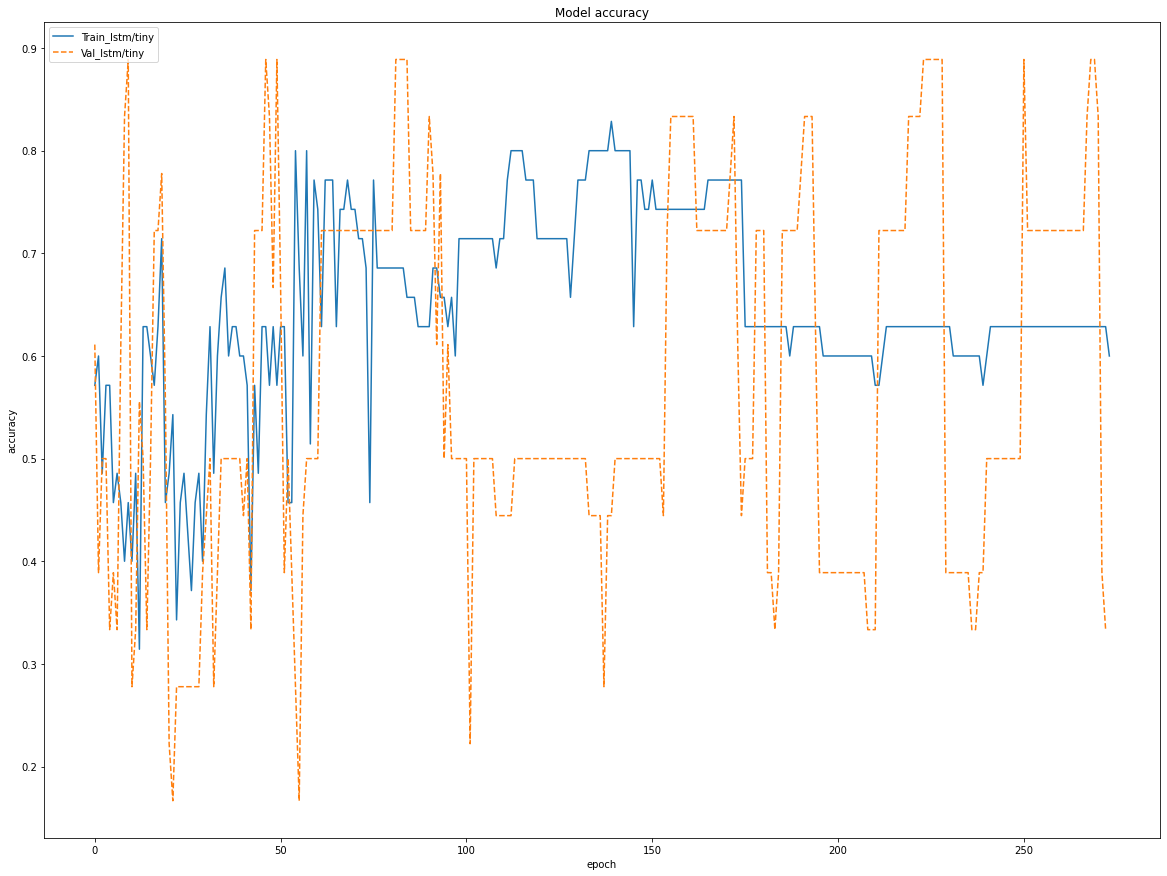

In [43]:
plot_report(lstm_histories, 'accuracy')

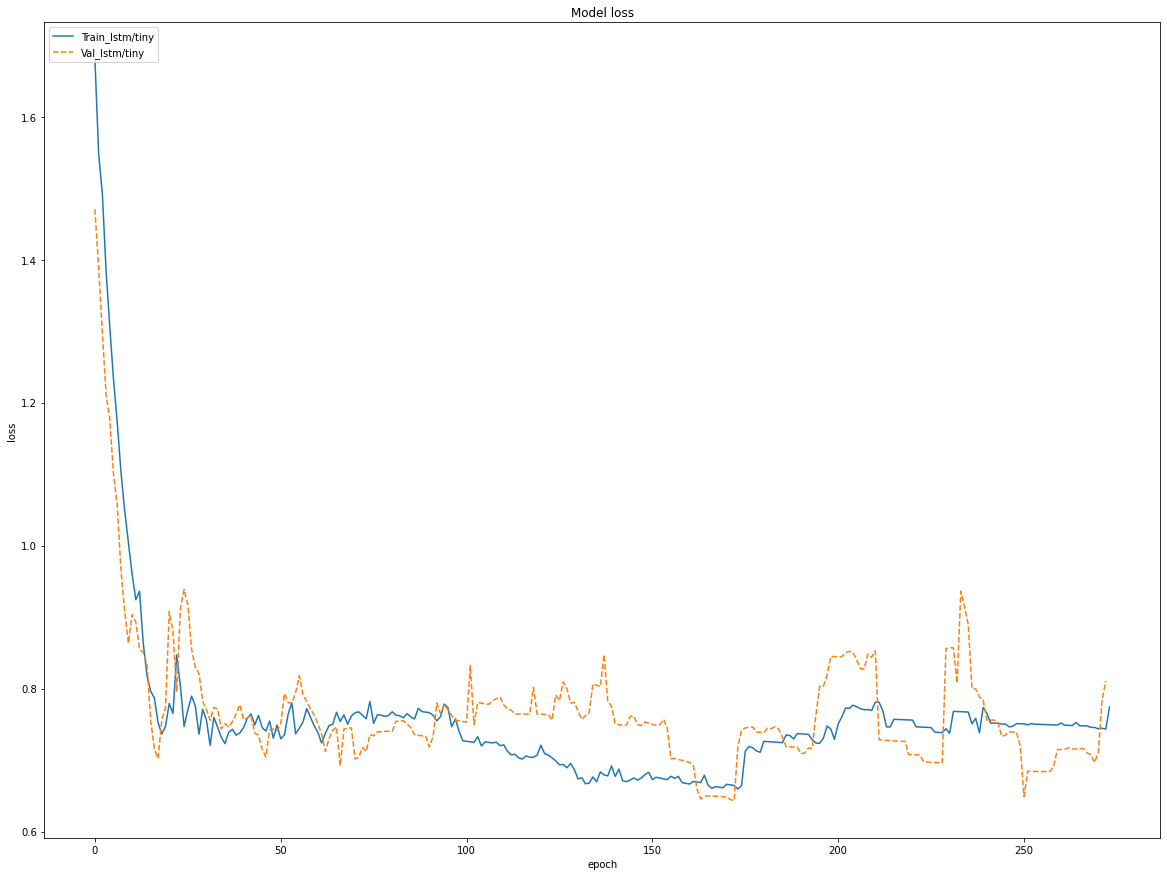

In [44]:
plot_report(lstm_histories, 'loss')

In [45]:
lstm_small_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[num_features,]),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/small'] = compile_and_fit(lstm_small_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                               name="lstm/small")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/small'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/small'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 16384)          0         
                                                                 
 lstm (LSTM)                 (None, 1, 128)            8454656   
                                                                 
 batch_normalization (BatchN  (None, 1, 128)           512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 8)                 1

1/1 [==============================] - 0s 14ms/step - loss: 0.9444 - accuracy: 0.5714 - val_loss: 0.8637 - val_accuracy: 0.7222
Epoch 48/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.8959 - accuracy: 0.4286 - val_loss: 0.8673 - val_accuracy: 0.7222
Epoch 49/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.9056 - accuracy: 0.4571 - val_loss: 0.8653 - val_accuracy: 0.7222
Epoch 50/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.9401 - accuracy: 0.5429 - val_loss: 0.8616 - val_accuracy: 0.7222
Epoch 51/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.9092 - accuracy: 0.5429 - val_loss: 0.8648 - val_accuracy: 0.7222
Epoch 52/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.9045 - accuracy: 0.4857 - val_loss: 0.8573 - val_accuracy: 0.7222
Epoch 53/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.8221 - accuracy: 0.5429 - val_loss: 0.8931 - val_accuracy: 0.7222
Epoch 54/1000
1/1 [=

Epoch 105/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.9085 - accuracy: 0.5429 - val_loss: 0.8887 - val_accuracy: 0.3333
Epoch 106/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.9397 - accuracy: 0.4000 - val_loss: 0.8900 - val_accuracy: 0.2778
Epoch 107/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.8584 - accuracy: 0.6000 - val_loss: 0.8868 - val_accuracy: 0.2778
Epoch 108/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.8527 - accuracy: 0.6000 - val_loss: 0.8920 - val_accuracy: 0.2778
Epoch 109/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.8776 - accuracy: 0.5714 - val_loss: 0.8917 - val_accuracy: 0.2778
Epoch 110/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.8541 - accuracy: 0.6000 - val_loss: 0.8917 - val_accuracy: 0.2778
Epoch 111/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.8527 - accuracy: 0.6000 - val_loss: 0.8909 - val_accuracy: 0.2778

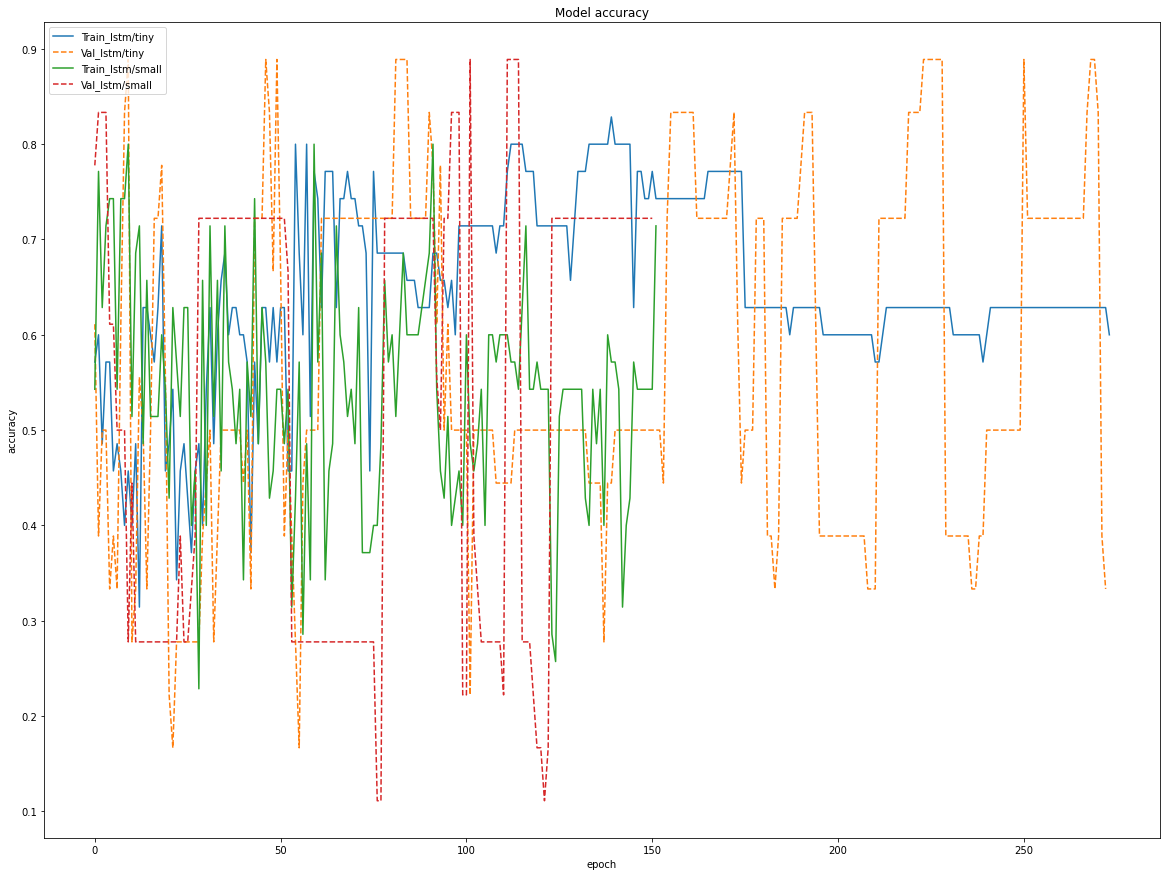

In [46]:
plot_report(lstm_histories, 'accuracy')

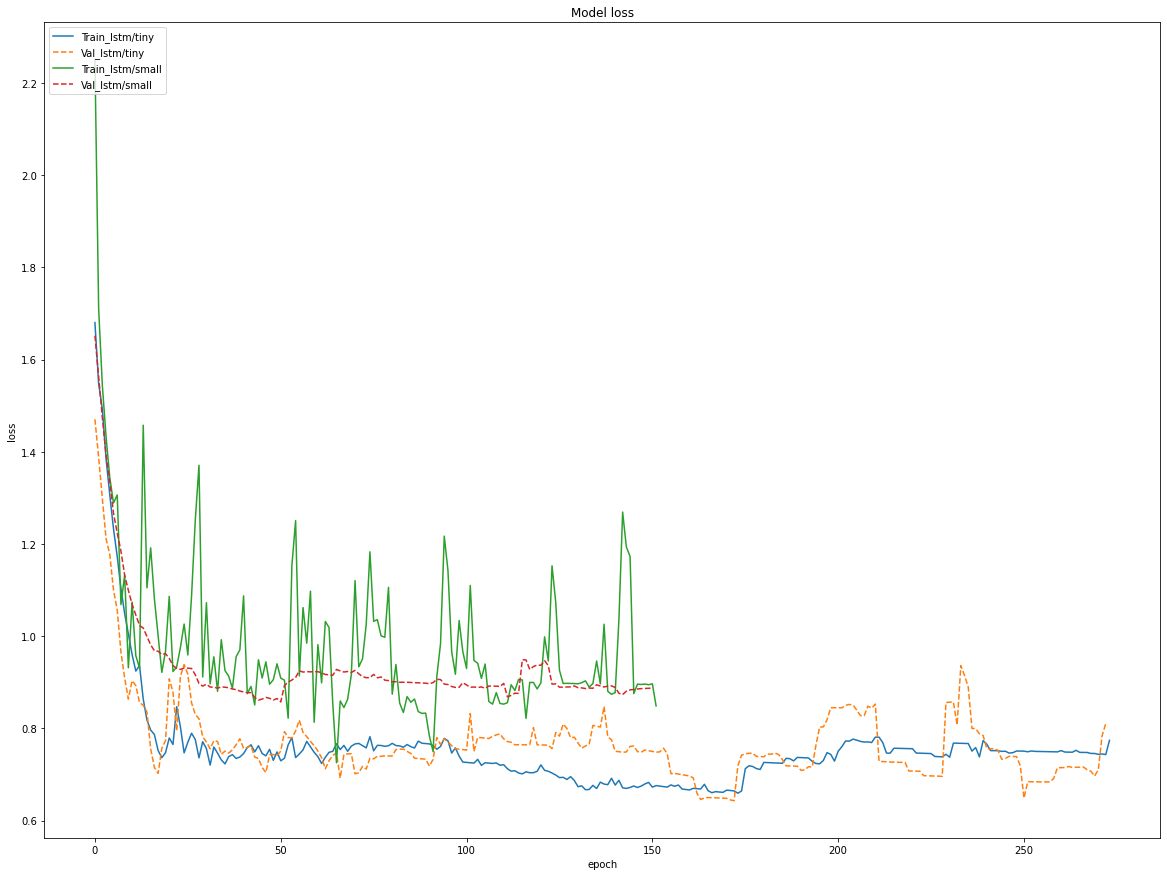

In [47]:
plot_report(lstm_histories, 'loss')

In [48]:
lstm_units=256
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_large_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[num_features,]),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/large'] = compile_and_fit(lstm_large_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                lr=1e-4,
#                                                multiplier=10), 
                                                name="lstm/large")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/large'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 16384)          0         
                                                                 
 lstm (LSTM)                 (None, 1, 256)            17040384  
                                                                 
 batch_normalization (BatchN  (None, 1, 256)           1024      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 64)                1

Epoch 39/1000
1/1 [==============================] - 0s 21ms/step - loss: 1.1323 - accuracy: 0.6000 - val_loss: 1.0618 - val_accuracy: 0.7222
Epoch 40/1000
1/1 [==============================] - 0s 19ms/step - loss: 1.2512 - accuracy: 0.5714 - val_loss: 1.0626 - val_accuracy: 0.7222
Epoch 41/1000
1/1 [==============================] - 0s 21ms/step - loss: 1.0100 - accuracy: 0.7143 - val_loss: 1.0611 - val_accuracy: 0.7222
Epoch 42/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.3139 - accuracy: 0.4857 - val_loss: 1.0589 - val_accuracy: 0.7222
Epoch 43/1000
1/1 [==============================] - 0s 19ms/step - loss: 1.1412 - accuracy: 0.6000 - val_loss: 1.0564 - val_accuracy: 0.7222
Epoch 44/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.5114 - accuracy: 0.4000 - val_loss: 1.0530 - val_accuracy: 0.7222
Epoch 45/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.2320 - accuracy: 0.6000 - val_loss: 1.0517 - val_accuracy: 0.7222
Epoch 

Epoch 97/1000
1/1 [==============================] - 0s 21ms/step - loss: 1.3300 - accuracy: 0.4857 - val_loss: 1.0454 - val_accuracy: 0.7222
Epoch 98/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.1876 - accuracy: 0.6000 - val_loss: 1.0454 - val_accuracy: 0.7222
Epoch 99/1000
1/1 [==============================] - 0s 21ms/step - loss: 1.1422 - accuracy: 0.6000 - val_loss: 1.0449 - val_accuracy: 0.7222
Epoch 100/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.0814 - accuracy: 0.6000 - val_loss: 1.0438 - val_accuracy: 0.7222
Epoch 101/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.2422 - accuracy: 0.5143 - val_loss: 1.0444 - val_accuracy: 0.7222
Epoch 102/1000
1/1 [==============================] - 0s 21ms/step - loss: 1.2807 - accuracy: 0.5143 - val_loss: 1.0436 - val_accuracy: 0.7222
Epoch 103/1000
1/1 [==============================] - 0s 19ms/step - loss: 1.0934 - accuracy: 0.6571 - val_loss: 1.0430 - val_accuracy: 0.7222
Ep

1/1 [==============================] - 0s 21ms/step - loss: 1.0730 - accuracy: 0.6000 - val_loss: 0.9969 - val_accuracy: 0.7222
Epoch 155/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.0664 - accuracy: 0.6000 - val_loss: 0.9966 - val_accuracy: 0.7222
Epoch 156/1000
1/1 [==============================] - 0s 19ms/step - loss: 1.0244 - accuracy: 0.6571 - val_loss: 1.0016 - val_accuracy: 0.7222
Epoch 157/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.0924 - accuracy: 0.6000 - val_loss: 0.9963 - val_accuracy: 0.7222
Epoch 158/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.0799 - accuracy: 0.6000 - val_loss: 0.9959 - val_accuracy: 0.7222
Epoch 159/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.0817 - accuracy: 0.5714 - val_loss: 0.9956 - val_accuracy: 0.7222
Epoch 160/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.1066 - accuracy: 0.5429 - val_loss: 0.9981 - val_accuracy: 0.7222
Epoch 161/1000

1/1 [==============================] - 0s 19ms/step - loss: 1.0318 - accuracy: 0.6857 - val_loss: 1.0287 - val_accuracy: 0.7222
Epoch 212/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.9689 - accuracy: 0.6571 - val_loss: 1.0226 - val_accuracy: 0.7222
Epoch 213/1000
1/1 [==============================] - 0s 19ms/step - loss: 1.0145 - accuracy: 0.5714 - val_loss: 1.0228 - val_accuracy: 0.7222
Epoch 214/1000
1/1 [==============================] - 0s 19ms/step - loss: 1.0074 - accuracy: 0.7143 - val_loss: 1.0230 - val_accuracy: 0.7222
Epoch 215/1000
1/1 [==============================] - 0s 19ms/step - loss: 1.0329 - accuracy: 0.6286 - val_loss: 1.0232 - val_accuracy: 0.7222
Epoch 216/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.0578 - accuracy: 0.6000 - val_loss: 1.0848 - val_accuracy: 0.7222
Epoch 217/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.9975 - accuracy: 0.6286 - val_loss: 1.0005 - val_accuracy: 0.7222
Epoch 218/1000

1/1 [==============================] - 0s 20ms/step - loss: 1.0054 - accuracy: 0.6857 - val_loss: 1.0352 - val_accuracy: 0.5556
Epoch 269/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.8627 - accuracy: 0.7714 - val_loss: 1.0206 - val_accuracy: 0.6111
Epoch 270/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.9341 - accuracy: 0.7143 - val_loss: 1.0220 - val_accuracy: 0.6667
Epoch 271/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.0117 - accuracy: 0.5714 - val_loss: 1.0153 - val_accuracy: 0.7222
Epoch 272/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.0552 - accuracy: 0.5714 - val_loss: 1.0140 - val_accuracy: 0.7222
Epoch 273/1000
1/1 [==============================] - 0s 19ms/step - loss: 1.0010 - accuracy: 0.6286 - val_loss: 1.0178 - val_accuracy: 0.7222
Epoch 274/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.9693 - accuracy: 0.6857 - val_loss: 1.0094 - val_accuracy: 0.7222
Epoch 275/1000

1/1 [==============================] - 0s 21ms/step - loss: 1.0440 - accuracy: 0.5714 - val_loss: 0.9878 - val_accuracy: 0.7222
Epoch 326/1000
1/1 [==============================] - 0s 19ms/step - loss: 1.1578 - accuracy: 0.4857 - val_loss: 0.9859 - val_accuracy: 0.7222
Epoch 327/1000
1/1 [==============================] - 0s 19ms/step - loss: 1.0764 - accuracy: 0.5714 - val_loss: 0.9901 - val_accuracy: 0.7222
Epoch 328/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.9697 - accuracy: 0.6857 - val_loss: 0.9449 - val_accuracy: 0.7222
Epoch 329/1000
1/1 [==============================] - 0s 19ms/step - loss: 1.0107 - accuracy: 0.6857 - val_loss: 0.9520 - val_accuracy: 0.7222
Epoch 330/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.9167 - accuracy: 0.6571 - val_loss: 0.9754 - val_accuracy: 0.7222
Epoch 331/1000
1/1 [==============================] - 0s 22ms/step - loss: 1.0471 - accuracy: 0.5714 - val_loss: 0.9880 - val_accuracy: 0.7222
Epoch 332/1000

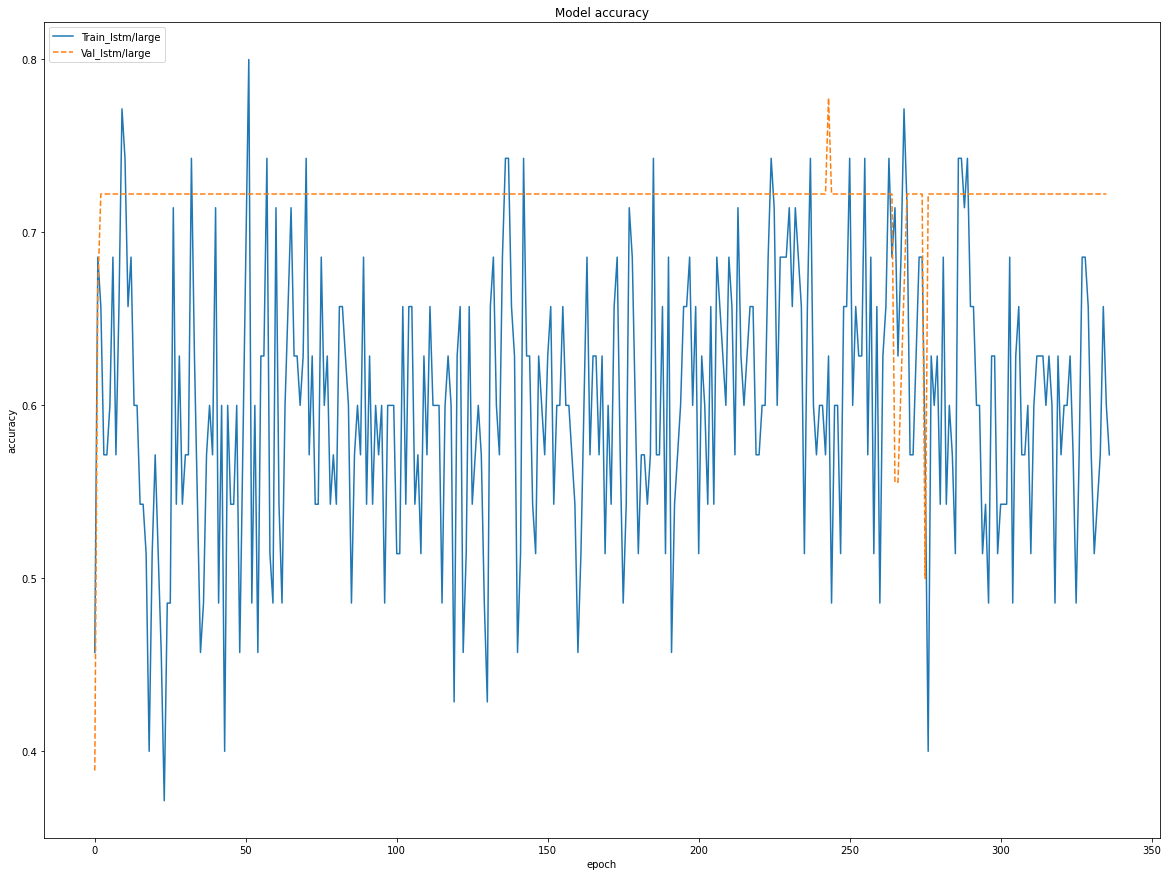

In [49]:
plot_report({'lstm/large':lstm_histories['lstm/large']}, 'accuracy')

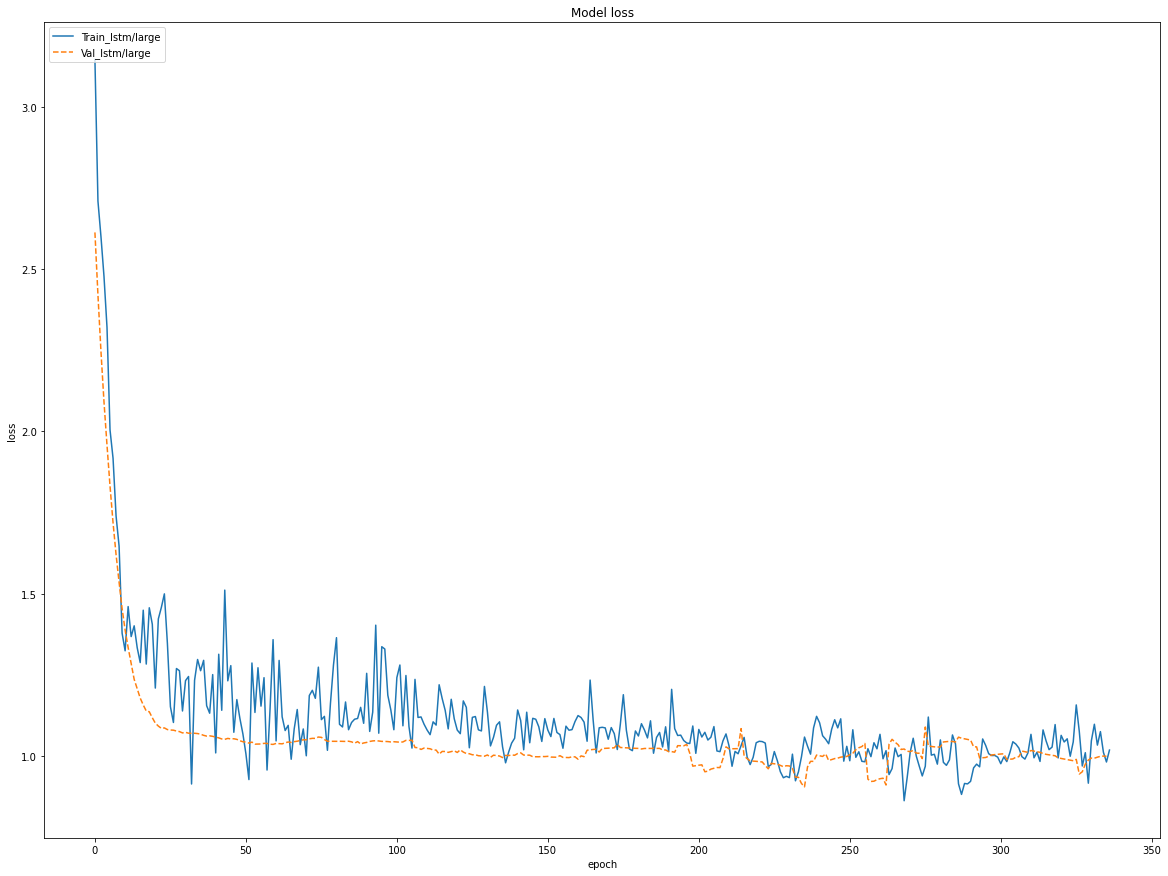

In [50]:
plot_report({'lstm/large':lstm_histories['lstm/large']}, 'loss')